Notebook: Estudo da variação de norma e janela para sinais sem ruído

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal.windows import hann, boxcar, flattop
from matplotlib import gridspec
import json

In [2]:
import pandas as pd
from IPython.display import display, HTML

In [3]:
import utils
import functions_for_param_study as funcstud

In [4]:
def get_result_table(dict_multinfo,norm_names,window_names):
    """
    Define DF to print results obtained for multiple norms and windows.
    Inputs:
    dict_multinfo: dict with keys 'NAA', 'GABA' and 'Glx', for each key there is a list of dicts with the information for each window within each norm
                    example: dict_multinfo['NAA'][0] = {'mean': [a,b,c,d],
                                                        'std': [1,2,3,4]} -> mean information obtained four norm of idx 0 and with each of the four 
                                                                            windows consired, accompanied by their respective std of the measured mean value
    norm_names: list with the names of each norm (in the same order they appear in dict_multinfo['NAA'])
    window_names: list with the names of each window (in the same order they appear in dict_multinfo['NAA'][0])
    """
    struct = {}
    for ele in ['NAA','GABA','Glx']:
        for j in range(len(window_names)):
            struct[(ele, window_names[j])] = []
            for i in range(len(norm_names)):
                struct[(ele, window_names[j])].append("{:.2e}".format(dict_multinfo[ele][i]['mean'][j]) + '±' + "{:.2e}".format(dict_multinfo[ele][i]['std'][j]))
               
    df = pd.DataFrame(struct, index=norm_names)
    display(HTML(df.to_html()))

Aquisição dos sinais simulados e geração dos espectrogramas:

In [5]:
qntty = 100
test_not_save = False

In [6]:
#Import data obtained on EditedMRS_Reconstruction_Challenge github -- Ground-truths
with h5py.File('../sample_data.h5') as hf:
  print(hf.keys())
  gt_fids = hf["ground_truth_fids"][()][:qntty]
  ppm = hf["ppm"][()][:qntty]
  t = hf["t"][()][:qntty]
  print(gt_fids.shape)
  print(ppm.shape)
  print(t.shape)

<KeysViewHDF5 ['ground_truth_fids', 'ppm', 't']>
(100, 2048, 2)
(100, 2048)
(100, 2048)


In [7]:
dwelltime = t[0,1]-t[0,0]
bandwidth = 1/dwelltime
N = gt_fids.shape[1]

#gts
spectra_gt_fids = np.fft.fftshift(np.fft.ifft(gt_fids,n=N,axis = 1), axes = 1)
spectra_gt_diff = spectra_gt_fids[:,:,1] - spectra_gt_fids[:,:,0]
freq = np.flip(np.fft.fftshift(np.fft.fftfreq(N, d = dwelltime)))

#to get ppm axis
idx_min = np.real(spectra_gt_diff[0,:]).argmin()
idx_max = np.real(spectra_gt_diff[0,:]).argmax()
#p = a*f + b
a = (ppm[0,idx_max] - ppm[0,idx_min])/(freq[idx_max]-freq[idx_min])
b = ppm[0,idx_max] - a*freq[idx_max]
#ppm_aux = b + freq*a

In [8]:
mfft_ = 512
window_ = [hann(mfft_,sym=True),boxcar(mfft_,sym=True),flattop(mfft_,sym=True)]
win_name =['hann','rect','flat']
hop_ = 8
norm_ = ['abs','m1p1','minmax','zscore']
spgram_wn = {}
for i in range(len(norm_)):
    spgram_wn['norm_'+norm_[i]] = {}
for i in range(len(norm_)):
    for j in range(len(window_)):
        spgram_gt, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=gt_fids[:,:,1]-gt_fids[:,:,0],bandwidth=bandwidth,window=window_[j],mfft=mfft_,hop=hop_,norm=norm_[i],correct_time=True,a=a,b=b)
        spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]] = [spgram_gt, freq_spect, ppm_spect, t_spect]

Algumas colunas e linhas de interesse na análise dos espectrogramas:

In [9]:
idx_time_0d05 = [] 
idx_time_0d4 = []
idx_time_0d6 = [] 
idx_freq_0ppm = [] 
idx_freq_1ppm = [] 
idx_freq_4ppm = [] 
idx_freq_8ppm = [] 
idx_freq_8d5ppm = []
idx_freq_NAA = [] 
idx_freq_GABA = []
idx_freq_Glx = []
for i in range(len(norm_)):
    list_of_t_spects = []
    list_of_ppm_spects = []
    for j in range(len(window_)):
        list_of_t_spects.append(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][-1])
        list_of_ppm_spects.append(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][2])
    idx_time_0d05.append(utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.05))
    idx_time_0d4.append(utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.4))
    idx_time_0d6.append(utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.6))
    idx_freq_0ppm.append(utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=0))
    idx_freq_1ppm.append(utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=1))
    idx_freq_4ppm.append(utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=4))
    idx_freq_8ppm.append(utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=8))
    idx_freq_8d5ppm.append(utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=8.5))
    idx_freq_NAA.append(utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=2.02))
    idx_freq_GABA.append(utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.00))
    idx_freq_Glx.append(utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.75))

Visualização de espectrogramas obtidos com diferentes janelas e normas:

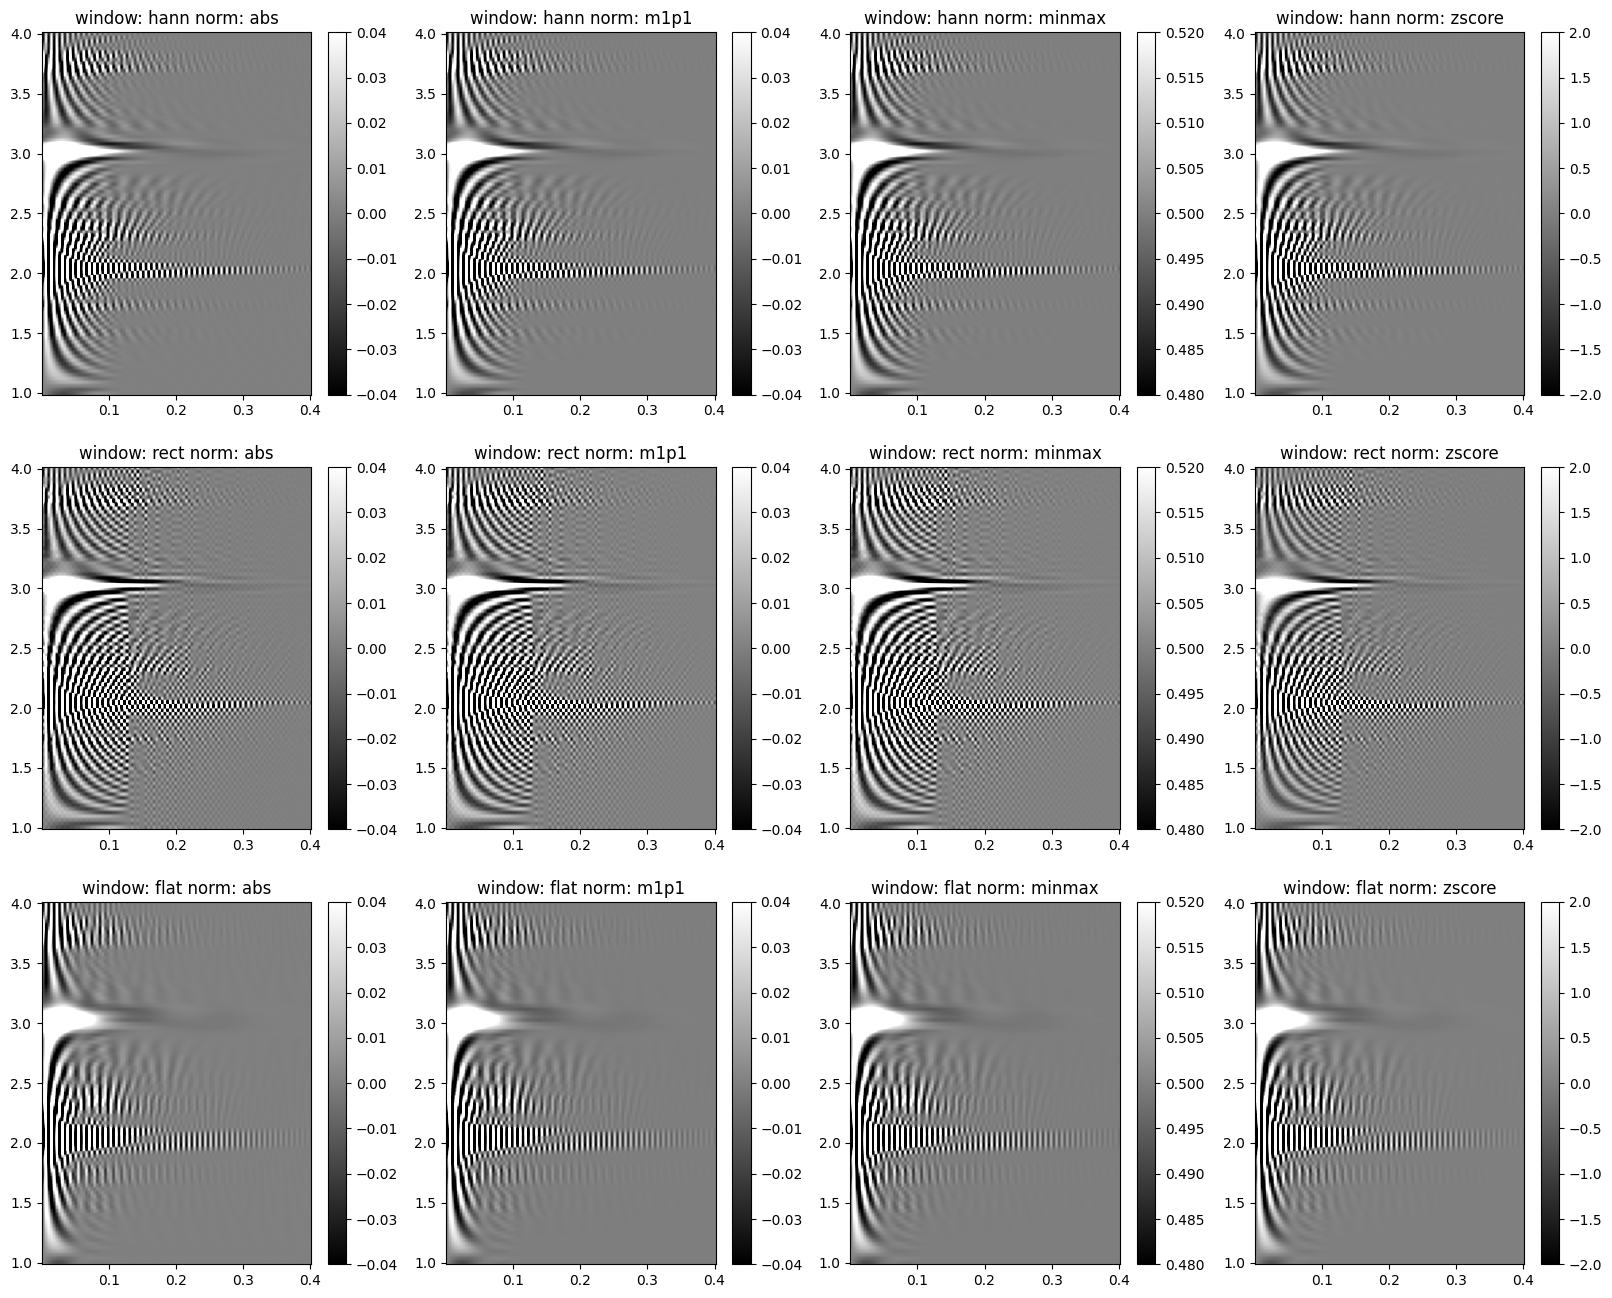

In [10]:
window_by_column = False
if window_by_column == True:
    fig,ax = plt.subplots(4,3,figsize=(20,20))
else: 
    fig,ax = plt.subplots(3,4,figsize=(20,16))
for i in range(len(norm_)):
    for j in range(len(window_)):
        if norm_[i] == 'abs' or norm_[i] == 'm1p1':
            vmin_ = -0.04
            vmax_ = 0.04
        elif norm_[i] == 'minmax':
            vmin_ = 0.48
            vmax_ = 0.52
        else:
            vmin_ = -2
            vmax_ = 2
        if window_by_column == True:
            plot_idx = 3*i+j
        else:
            plot_idx = 4*j+i
        im = ax.flat[plot_idx].imshow(np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0][0,idx_freq_1ppm[i][j]:idx_freq_4ppm[i][j],:idx_time_0d4[i][j]]), origin='lower', aspect='auto',cmap='gray',
          vmin=vmin_,vmax=vmax_,
          extent = (spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][-1][0],
                    spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][-1][idx_time_0d4[i][j]],
                    np.flip(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][2])[idx_freq_1ppm[i][j]],
                    np.flip(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][2])[idx_freq_4ppm[i][j]]))
        ax.flat[plot_idx].set_title('window: '+win_name[j]+' norm: '+norm_[i])
        if window_by_column == False:
            fig.colorbar(im, ax=ax[j,i])
    if window_by_column == True:
        fig.colorbar(im, ax=ax[i,:])

Projeção no eixo da frequência para diferentes janelas e normas:

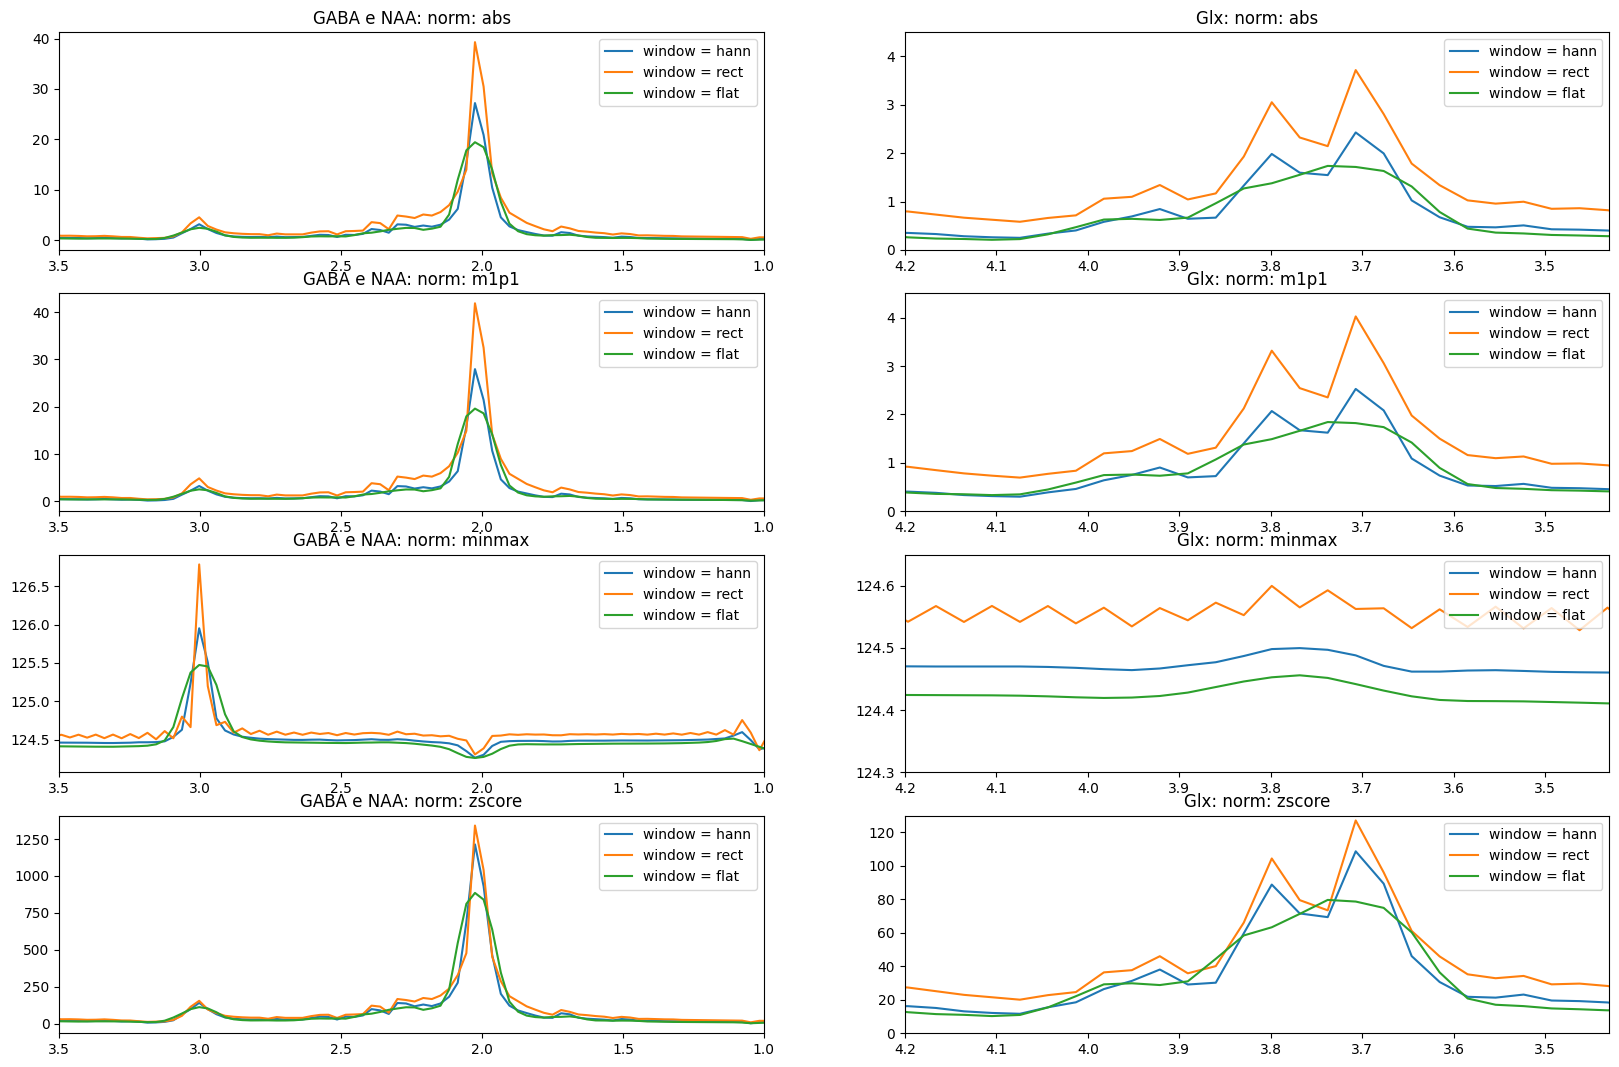

In [11]:
plot_abs = True
window_var = True
if window_var == True:
    fig,ax = plt.subplots(4,2,figsize=(20,13))
else:
    fig,ax = plt.subplots(3,2,figsize=(20,10))
for i in range(len(norm_)):
    for j in range(len(window_)):
        if plot_abs == True:
            aux = np.sum(np.abs(np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0][0,:,:])),axis=1)
        else:
            aux = np.sum(np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0][0,:,:]),axis=1)
        if window_var == True:
            ax.flat[2*i].plot(np.flip(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][2]),aux,label='window = '+win_name[j])
            ax.flat[2*i+1].plot(np.flip(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][2]),aux,label='window = '+win_name[j])
        else:
            if norm_[i] == 'abs' or norm_[i] == 'm1p1':
                scale = 1
                pos = 0
            elif norm_[i] == 'zscore':
                scale = 40
                pos = 0
            else:
                if plot_abs == True:
                    scale = 0.1
                    pos = -1244
                else:
                    scale = 0.8
                    pos = -155.7
            ax.flat[2*j].plot(np.flip(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][2]),aux/scale + pos,label='norm = '+norm_[i])
            ax.flat[2*j+1].plot(np.flip(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][2]),aux/scale + pos,label='norm = '+norm_[i])
if window_var == True:
    for i in range(len(norm_)):
            ax.flat[2*i].set_title('GABA e NAA: norm: '+norm_[i])
            ax.flat[2*i+1].set_title('Glx: norm: '+norm_[i])
            ax.flat[2*i].set_xlim(3.5,1)  
            ax.flat[2*i+1].set_xlim(4.2,3.43)
            ax.flat[2*i].legend(loc='upper right')  
            ax.flat[2*i+1].legend(loc='upper right')
    if plot_abs == True:
        ax.flat[1].set_ylim(0,4.5)
        ax.flat[3].set_ylim(0,4.5)
        ax.flat[5].set_ylim(124.3,124.65)
        ax.flat[7].set_ylim(0,130)
    else:
        ax.flat[1].set_ylim(-0.1,0.1)
        ax.flat[3].set_ylim(-0.2,0.3)
        ax.flat[5].set_ylim(124.35,124.65)
        ax.flat[7].set_ylim(-2.5,2.5)
else:
    for j in range(len(window_)):
        ax.flat[2*j].set_title('GABA e NAA: window: '+win_name[j])
        ax.flat[2*j+1].set_title('Glx: window: '+win_name[j])
        ax.flat[2*j].set_xlim(3.5,1)  
        ax.flat[2*j+1].set_xlim(4.2,3.43)
        ax.flat[2*j].legend(loc='upper right')  
        ax.flat[2*j+1].legend(loc='upper right')
    if plot_abs == True:
        ax.flat[1].set_ylim(0,4.5)
        ax.flat[3].set_ylim(0,4.5)
        ax.flat[5].set_ylim(0,4.5)
    else:
        ax.flat[1].set_ylim(-0.2,0.1)
        ax.flat[3].set_ylim(-0.08,0.22)
        ax.flat[5].set_ylim(-0.2,0.1)

Medição da FWHM das projeções para os picos de NAA, GABA e Glx:

In [12]:
fwhm_wn = {'NAA':[],'GABA':[],'Glx':[]}
fwhm_wn_real = {'NAA':[],'GABA':[],'Glx':[]}
idx_fwhm = {}
idx_fwhm_real = {}
for i in range(len(norm_)):
    list_projections_abs = []
    list_projections_real = []
    list_of_ppm_spects = []
    idx_fwhm['norm_'+norm_[i]] = {}
    idx_fwhm_real['norm_'+norm_[i]] = {}
    for j in range(len(window_)):
        if norm_[i] == 'minmax':
            #correcao pois não está centralizado em 0
            aux_mean_minmax = np.mean(np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0]),axis=(1,2),keepdims=True)
            aux_minmax = np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0]) - aux_mean_minmax
            aux_abs = np.sum(np.abs(aux_minmax),axis=2)
            aux_real = np.sum(aux_minmax,axis=2)
        else:
            aux_abs = np.sum(np.abs(np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0])),axis=2)
            aux_real = np.sum(np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0]),axis=2)
            
        list_projections_abs.append(aux_abs)
        list_projections_real.append(aux_real)
        list_of_ppm_spects.append(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][2])
        idx_fwhm['norm_'+norm_[i]]['window_'+win_name[j]] = {}
        idx_fwhm_real['norm_'+norm_[i]]['window_'+win_name[j]] = {}
    fwhm_wn['NAA'].append([])
    fwhm_wn['NAA'][i], aux_idx_NAA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs,list_peak_idx=idx_freq_NAA[i],list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='positive')
    fwhm_wn['GABA'].append([])
    fwhm_wn['GABA'][i], aux_idx_GABA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs,list_peak_idx=idx_freq_GABA[i],list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
    fwhm_wn['Glx'].append([])
    fwhm_wn['Glx'][i], aux_idx_Glx_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs,list_peak_idx=idx_freq_Glx[i],list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')
    
    fwhm_wn_real['NAA'].append([])      
    fwhm_wn_real['NAA'][i], aux_idx_NAA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real,list_peak_idx=idx_freq_NAA[i],list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
    fwhm_wn_real['GABA'].append([])      
    fwhm_wn_real['GABA'][i], aux_idx_GABA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real,list_peak_idx=idx_freq_GABA[i],list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
    fwhm_wn_real['Glx'].append([])      
    fwhm_wn_real['Glx'][i], aux_idx_Glx_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real,list_peak_idx=idx_freq_Glx[i],list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')
    
    for j in range(len(window_)):
        idx_fwhm['norm_'+norm_[i]]['window_'+win_name[j]]['NAA'] = aux_idx_NAA_abs[j]
        idx_fwhm['norm_'+norm_[i]]['window_'+win_name[j]]['GABA'] = aux_idx_GABA_abs[j]
        idx_fwhm['norm_'+norm_[i]]['window_'+win_name[j]]['Glx'] = aux_idx_Glx_abs[j]
        
        idx_fwhm_real['norm_'+norm_[i]]['window_'+win_name[j]]['NAA'] = aux_idx_NAA_real[j]
        idx_fwhm_real['norm_'+norm_[i]]['window_'+win_name[j]]['GABA'] = aux_idx_GABA_real[j]
        idx_fwhm_real['norm_'+norm_[i]]['window_'+win_name[j]]['Glx'] = aux_idx_Glx_real[j]

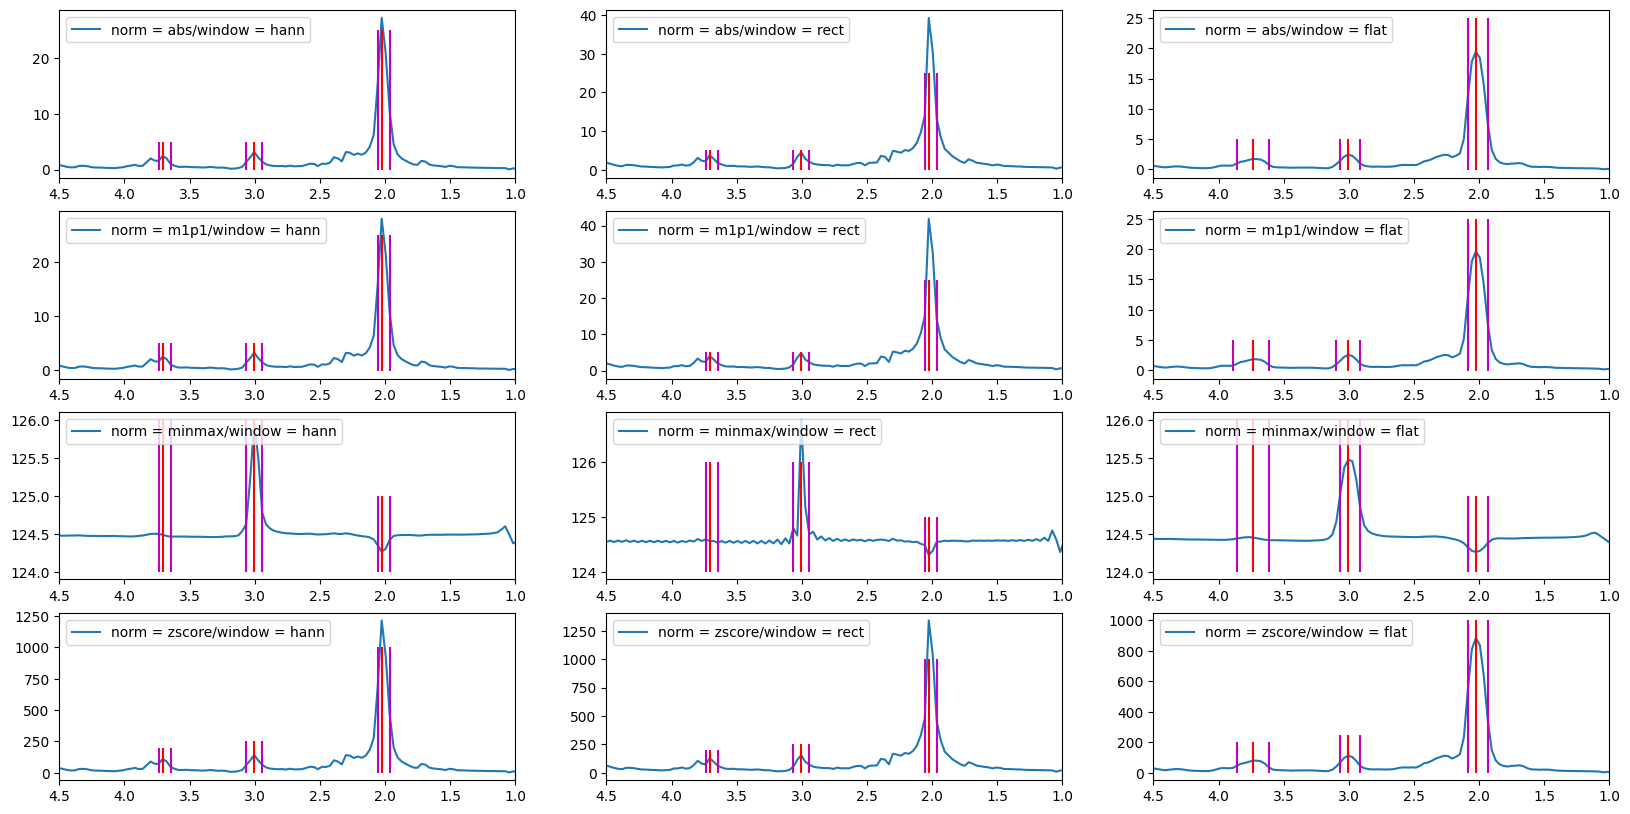

In [13]:
plot_abs = True
fig,ax = plt.subplots(4,3,figsize=(20,10))
count = 0
for i in range(len(norm_)):
    for j in range(len(window_)):
        if plot_abs == True:
            aux = np.sum(np.abs(np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0][0,:,:])),axis=1)
        else:
            aux = np.sum(np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0][0,:,:]),axis=1)
        ax.flat[count].plot(np.flip(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][2]),aux,label='norm = '+norm_[i]+'/window = '+win_name[j])
        ax.flat[count].set_xlim(4.5,1)
        if i == 0 or i == 1:
            if plot_abs == True:
                lim_NAA = 25
                lim_GABA = 5
                lim_Glx = 5
            else:
                lim_NAA = -1
                lim_GABA = 2
                lim_Glx = 1
            lim_inf = -0.1
        elif i == 2:
            if plot_abs == True:
                lim_NAA = 125
                lim_GABA = 126
                lim_Glx = 126
            else:
                lim_NAA = 124.5
                lim_GABA = 126
                lim_Glx = 126
            lim_inf = 124
        else:
            if plot_abs == True:
                lim_NAA = 1000
                lim_GABA = 250
                lim_Glx = 200
            else:
                lim_NAA = -15
                lim_GABA = 110
                lim_Glx = 25
            lim_inf = 0
        if plot_abs == True:
            idx_carrier = idx_fwhm['norm_'+norm_[i]]['window_'+win_name[j]]
        else:
            idx_carrier = idx_fwhm_real['norm_'+norm_[i]]['window_'+win_name[j]]
        ax.flat[count].vlines(np.flip(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][2])[int(idx_carrier['NAA'][0,2])],lim_inf,lim_NAA,color='r')
        ax.flat[count].vlines(np.flip(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][2])[int(idx_carrier['NAA'][0,0])],lim_inf,lim_NAA,color='m')
        ax.flat[count].vlines(np.flip(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][2])[int(idx_carrier['NAA'][0,1])],lim_inf,lim_NAA,color='m')
        ax.flat[count].vlines(np.flip(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][2])[int(idx_carrier['GABA'][0,2])],lim_inf,lim_GABA,color='r')        
        ax.flat[count].vlines(np.flip(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][2])[int(idx_carrier['GABA'][0,0])],lim_inf,lim_GABA,color='m')
        ax.flat[count].vlines(np.flip(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][2])[int(idx_carrier['GABA'][0,1])],lim_inf,lim_GABA,color='m')
        ax.flat[count].vlines(np.flip(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][2])[int(idx_carrier['Glx'][0,2])],lim_inf,lim_Glx,color='r')        
        ax.flat[count].vlines(np.flip(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][2])[int(idx_carrier['Glx'][0,0])],lim_inf,lim_Glx,color='m')
        ax.flat[count].vlines(np.flip(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][2])[int(idx_carrier['Glx'][0,1])],lim_inf,lim_Glx,color='m')
        ax.flat[count].legend(loc='upper left')
        count = count + 1

In [14]:
 get_result_table(fwhm_wn,norm_,win_name)

In [15]:
 get_result_table(fwhm_wn_real,norm_,win_name)

Espectrogramas concatenados:

In [16]:
concat_by_norm = {}
for i in range(len(norm_)):
    concat_by_norm['norm_'+norm_[i]] = utils.concatenate_generic(selected_keys=list(spgram_wn['norm_'+norm_[i]].keys()),spgram_dict=spgram_wn['norm_'+norm_[i]],list_time_idx=idx_time_0d4[i],fid_idx_plot=0)

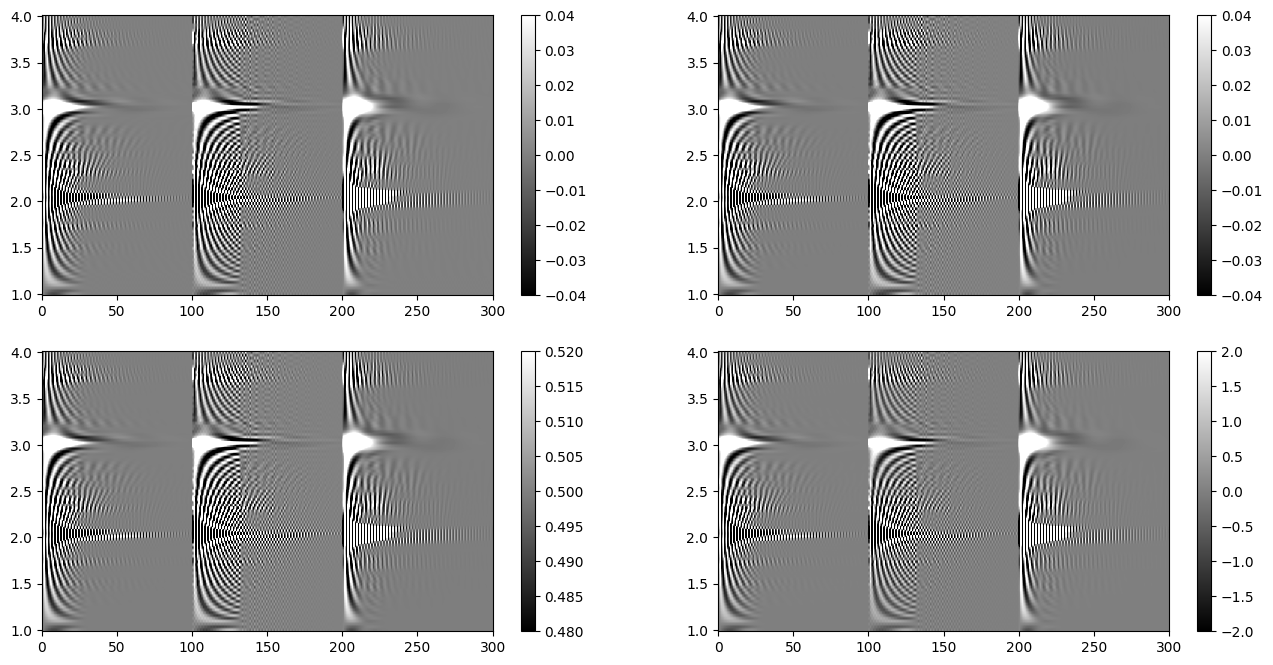

In [17]:
fig,ax = plt.subplots(2,2,figsize=(16,8))
im = ax[0,0].imshow(np.real(concat_by_norm['norm_'+norm_[0]][idx_freq_1ppm[0][0]:idx_freq_4ppm[0][0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,concat_by_norm['norm_'+norm_[0]].shape[-1],np.flip(spgram_wn['norm_'+norm_[0]]['window_'+win_name[0]][2])[idx_freq_1ppm[0][0]],np.flip(spgram_wn['norm_'+norm_[0]]['window_'+win_name[0]][2])[idx_freq_4ppm[0][0]]))
fig.colorbar(im, ax=ax[0,0])
im = ax[0,1].imshow(np.real(concat_by_norm['norm_'+norm_[1]][idx_freq_1ppm[0][0]:idx_freq_4ppm[0][0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,concat_by_norm['norm_'+norm_[1]].shape[-1],np.flip(spgram_wn['norm_'+norm_[1]]['window_'+win_name[0]][2])[idx_freq_1ppm[1][0]],np.flip(spgram_wn['norm_'+norm_[1]]['window_'+win_name[0]][2])[idx_freq_4ppm[1][0]]))
fig.colorbar(im, ax=ax[0,1])
im = ax[1,0].imshow(np.real(concat_by_norm['norm_'+norm_[2]][idx_freq_1ppm[0][0]:idx_freq_4ppm[0][0],:]), origin='lower', aspect='auto',cmap='gray',vmin=0.48,vmax=0.52,
          extent = (0,concat_by_norm['norm_'+norm_[2]].shape[-1],np.flip(spgram_wn['norm_'+norm_[2]]['window_'+win_name[0]][2])[idx_freq_1ppm[2][0]],np.flip(spgram_wn['norm_'+norm_[2]]['window_'+win_name[0]][2])[idx_freq_4ppm[2][0]]))
fig.colorbar(im, ax=ax[1,0])
im = ax[1,1].imshow(np.real(concat_by_norm['norm_'+norm_[3]][idx_freq_1ppm[0][0]:idx_freq_4ppm[0][0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-2,vmax=2,
          extent = (0,concat_by_norm['norm_'+norm_[3]].shape[-1],np.flip(spgram_wn['norm_'+norm_[3]]['window_'+win_name[0]][2])[idx_freq_1ppm[3][0]],np.flip(spgram_wn['norm_'+norm_[3]]['window_'+win_name[0]][2])[idx_freq_4ppm[3][0]]))
fig.colorbar(im, ax=ax[1,1])

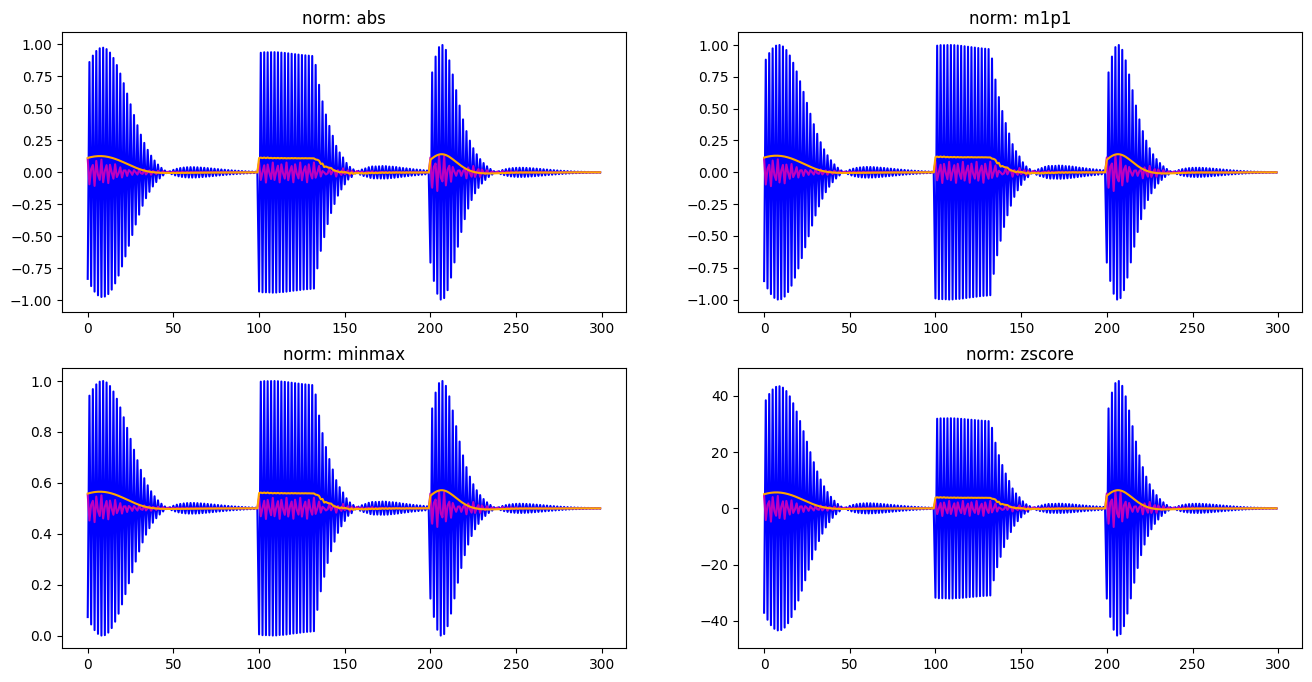

In [18]:
fig,ax = plt.subplots(2,2,figsize=(16,8))
for i in range(len(norm_)):
    ax.flat[i].plot(np.real(concat_by_norm['norm_'+norm_[i]][idx_freq_NAA[i][0],:]),color='b')
    ax.flat[i].plot(np.real(concat_by_norm['norm_'+norm_[i]][idx_freq_Glx[i][0],:]),color='m')
    ax.flat[i].plot(np.real(concat_by_norm['norm_'+norm_[i]][idx_freq_GABA[i][0],:]),color='orange')
    ax.flat[i].set_title('norm: '+norm_[i])

Medição do comprimento dos picos de GABA, NAA e Glx:

In [19]:
segm_dict = {}
sum_segment = {}
for i in range(len(norm_)):
    if norm_[i] == 'minmax':
        aux_dict = {}
        for j in range(len(window_)):
            aux_dict['window_'+win_name[j]] = [spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0]-0.5,spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][1],spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][2],spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][3]]
        segm_dict['norm_'+norm_[i]] = funcstud.segment_relevant_peaks_dict(spgram_dict=aux_dict,idx_list_1ppm=idx_freq_1ppm[i],idx_list_4ppm=idx_freq_4ppm[i],idx_list_GABA=idx_freq_GABA[i],idx_list_NAA=idx_freq_NAA[i],idx_list_Glx=idx_freq_Glx[i],idx_time_list_0d4=idx_time_0d4[i],idx_peaks_regions_limits_dict=idx_fwhm_real['norm_'+norm_[i]])
        sum_segment['norm_'+norm_[i]] = funcstud.get_length_relevant_peaks_for_different_spgrams(segm_dict=segm_dict['norm_'+norm_[i]],spgram_dict=aux_dict,idx_list_1ppm=idx_freq_1ppm[i],idx_list_4ppm=idx_freq_4ppm[i],idx_list_GABA=idx_freq_GABA[i],idx_list_NAA=idx_freq_NAA[i],idx_list_Glx=idx_freq_Glx[i])
    else: 
        segm_dict['norm_'+norm_[i]] = funcstud.segment_relevant_peaks_dict(spgram_dict=spgram_wn['norm_'+norm_[i]],idx_list_1ppm=idx_freq_1ppm[i],idx_list_4ppm=idx_freq_4ppm[i],idx_list_GABA=idx_freq_GABA[i],idx_list_NAA=idx_freq_NAA[i],idx_list_Glx=idx_freq_Glx[i],idx_time_list_0d4=idx_time_0d4[i],idx_peaks_regions_limits_dict=idx_fwhm_real['norm_'+norm_[i]])
        sum_segment['norm_'+norm_[i]] = funcstud.get_length_relevant_peaks_for_different_spgrams(segm_dict=segm_dict['norm_'+norm_[i]],spgram_dict=spgram_wn['norm_'+norm_[i]],idx_list_1ppm=idx_freq_1ppm[i],idx_list_4ppm=idx_freq_4ppm[i],idx_list_GABA=idx_freq_GABA[i],idx_list_NAA=idx_freq_NAA[i],idx_list_Glx=idx_freq_Glx[i])

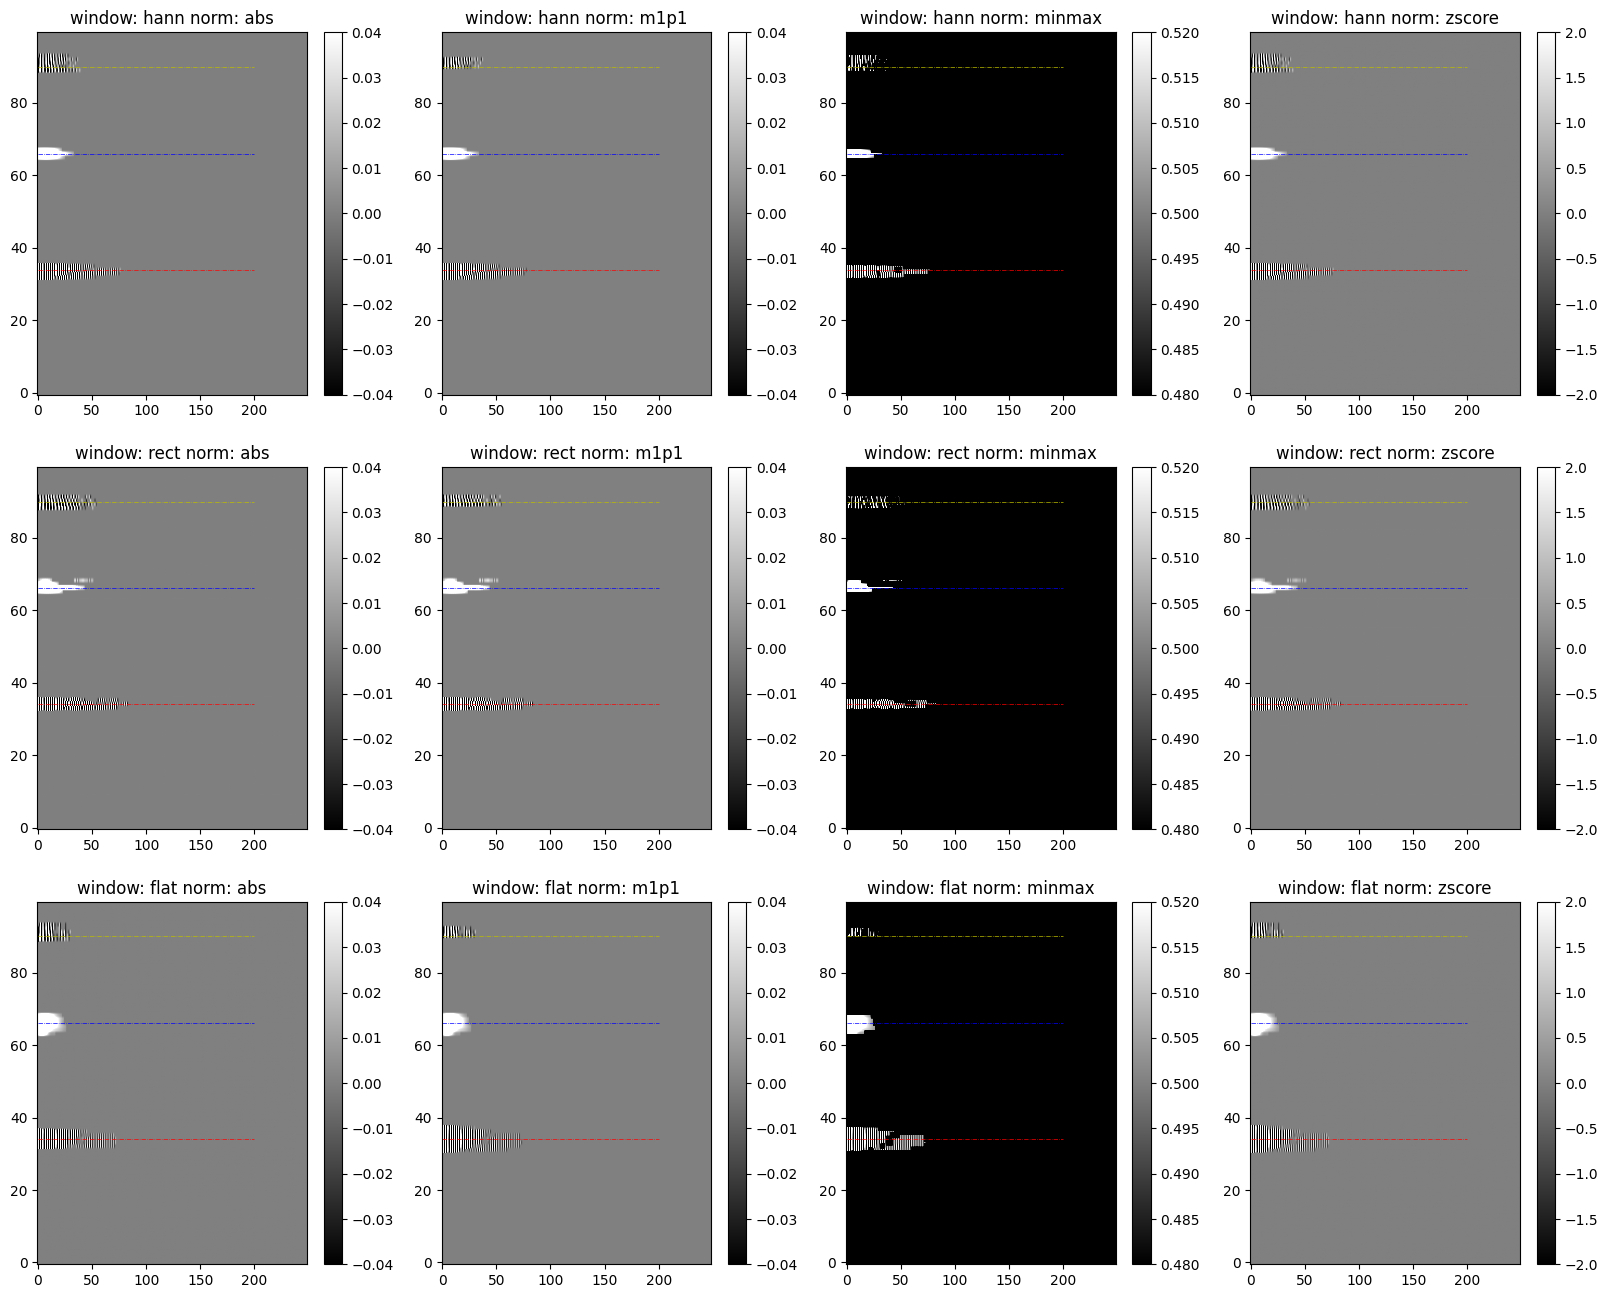

In [20]:
window_by_column = False
plot_binary = False
if window_by_column == True:
    fig,ax = plt.subplots(4,3,figsize=(20,20))
else: 
    fig,ax = plt.subplots(3,4,figsize=(20,16))
for i in range(len(norm_)):
    for j in range(len(window_)):
        if norm_[i] == 'abs' or norm_[i] == 'm1p1':
            vmin_ = -0.04
            vmax_ = 0.04
        elif norm_[i] == 'minmax':
            vmin_ = 0.48
            vmax_ = 0.52
        else:
            vmin_ = -2
            vmax_ = 2
        if window_by_column == True:
            plot_idx = 3*i+j
        else:
            plot_idx = 4*j+i
        if plot_binary == True:
            im = ax.flat[plot_idx].imshow(segm_dict['norm_'+norm_[i]]['window_'+win_name[j]][0,:,:],cmap='gray',aspect='auto',origin='lower')
        else:
            im = ax.flat[plot_idx].imshow(segm_dict['norm_'+norm_[i]]['window_'+win_name[j]][0,:,:]*np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0][0,idx_freq_1ppm[i][j]:idx_freq_4ppm[i][j]+1,:]),cmap='gray',aspect='auto',origin='lower',
                                          vmin=vmin_,vmax=vmax_)
        ax.flat[plot_idx].set_title('window: '+win_name[j]+' norm: '+norm_[i])
        ax.flat[plot_idx].hlines(idx_freq_NAA[i][j]-idx_freq_1ppm[i][j],0,200,color='r',linestyle='dashdot',linewidth=0.5)
        ax.flat[plot_idx].hlines(idx_freq_Glx[i][j]-idx_freq_1ppm[i][j],0,200,color='y',linestyle='dashdot',linewidth=0.5)
        ax.flat[plot_idx].hlines(idx_freq_GABA[i][j]-idx_freq_1ppm[i][j],0,200,color='b',linestyle='dashdot',linewidth=0.5)
        if window_by_column == False:
            fig.colorbar(im, ax=ax[j,i])
    if window_by_column == True:
        fig.colorbar(im, ax=ax[i,:])

In [21]:
sum_segment_df_form = {'NAA':[],'GABA':[],'Glx':[]}
for i in range(len(norm_)):
    sum_segment_df_form['NAA'].append(sum_segment['norm_'+norm_[i]]['NAA'])
    sum_segment_df_form['GABA'].append(sum_segment['norm_'+norm_[i]]['GABA'])
    sum_segment_df_form['Glx'].append(sum_segment['norm_'+norm_[i]]['Glx'])
get_result_table(sum_segment_df_form,norm_,win_name)

O padrão de listras das imagens muda com mfft?

In [22]:
zcr_ = {'NAA':[],'GABA':[],'Glx':[]}
for i in range(len(norm_)):
    zcr_aux = funcstud.get_zcr_for_relevant_peaks_for_different_spgrams(spgram_dict=spgram_wn['norm_'+norm_[i]],idx_list_GABA=idx_freq_GABA[i],idx_list_NAA=idx_freq_NAA[i],idx_list_Glx=idx_freq_Glx[i],idx_time_list_0d4=idx_time_0d4[i])
    for key in list(zcr_.keys()):
        zcr_[key].append(zcr_aux[key])

In [23]:
get_result_table(zcr_,norm_,win_name)

Get some statistical insights:

First, let's divide the image in sections of ppm:

In [24]:
sections = [-4,-3,-2,-1,0,1,1.50,2.50,3.50,4,5,6,7,8.50,9,10]
section_list = []
for k in range(1,len(sections)):
    section_list.append(str(sections[k-1])+':'+str(sections[k]))
section_list.append('residual')
max_sec = {}
for i in range(len(norm_)):
    max_sec['norm_'+norm_[i]] = {}
    for j in range(len(window_)):
        max_sec['norm_'+norm_[i]]['window_'+win_name[j]] = {'mean':[],'std':[]}

for i in range(len(norm_)):
    idx_time_list_sup = []
    for j in range(len(window_)):
        idx_time_list_sup.append([idx_time_0d05[i][j],idx_time_0d05[i][j],idx_time_0d05[i][j],idx_time_0d05[i][j],idx_time_0d05[i][j],
                                idx_time_0d4[i][j],idx_time_0d4[i][j],idx_time_0d4[i][j],idx_time_0d4[i][j],idx_time_0d4[i][j],
                                idx_time_0d05[i][j],idx_time_0d05[i][j],
                                idx_time_0d4[i][j],idx_time_0d05[i][j],idx_time_0d05[i][j]])
    max_sec_aux, mean_sec, std_sec = funcstud.get_max_mean_std_per_sections_for_different_spgrams(spgram_dict=spgram_wn['norm_'+norm_[i]], part='real', sections=sections, idx_time_list_sup=idx_time_list_sup)
    for j in range(len(window_)):
        for k in range(1,len(sections)):
            max_sec['norm_'+norm_[i]]['window_'+win_name[j]]['mean'].append(max_sec_aux[str(sections[k-1])+':'+str(sections[k])]['mean'][j])
            max_sec['norm_'+norm_[i]]['window_'+win_name[j]]['std'].append(max_sec_aux[str(sections[k-1])+':'+str(sections[k])]['std'][j])

for i in range(len(norm_)):
    idx_time_list_inf = []
    for j in range(len(window_)):
        idx_time_list_inf.append([idx_time_0d6[i][j]])
    max_sec_aux, mean_sec, std_sec = funcstud.get_max_mean_std_per_sections_for_different_spgrams(spgram_dict=spgram_wn['norm_'+norm_[i]], part='real', sections=[1,4], idx_time_list_inf=idx_time_list_inf)
    for j in range(len(window_)):
        max_sec['norm_'+norm_[i]]['window_'+win_name[j]]['mean'].append(max_sec_aux['1:4']['mean'][j])
        max_sec['norm_'+norm_[i]]['window_'+win_name[j]]['std'].append(max_sec_aux['1:4']['std'][j])

Observe how the maximum value changes in every region regarding to the norm and window:

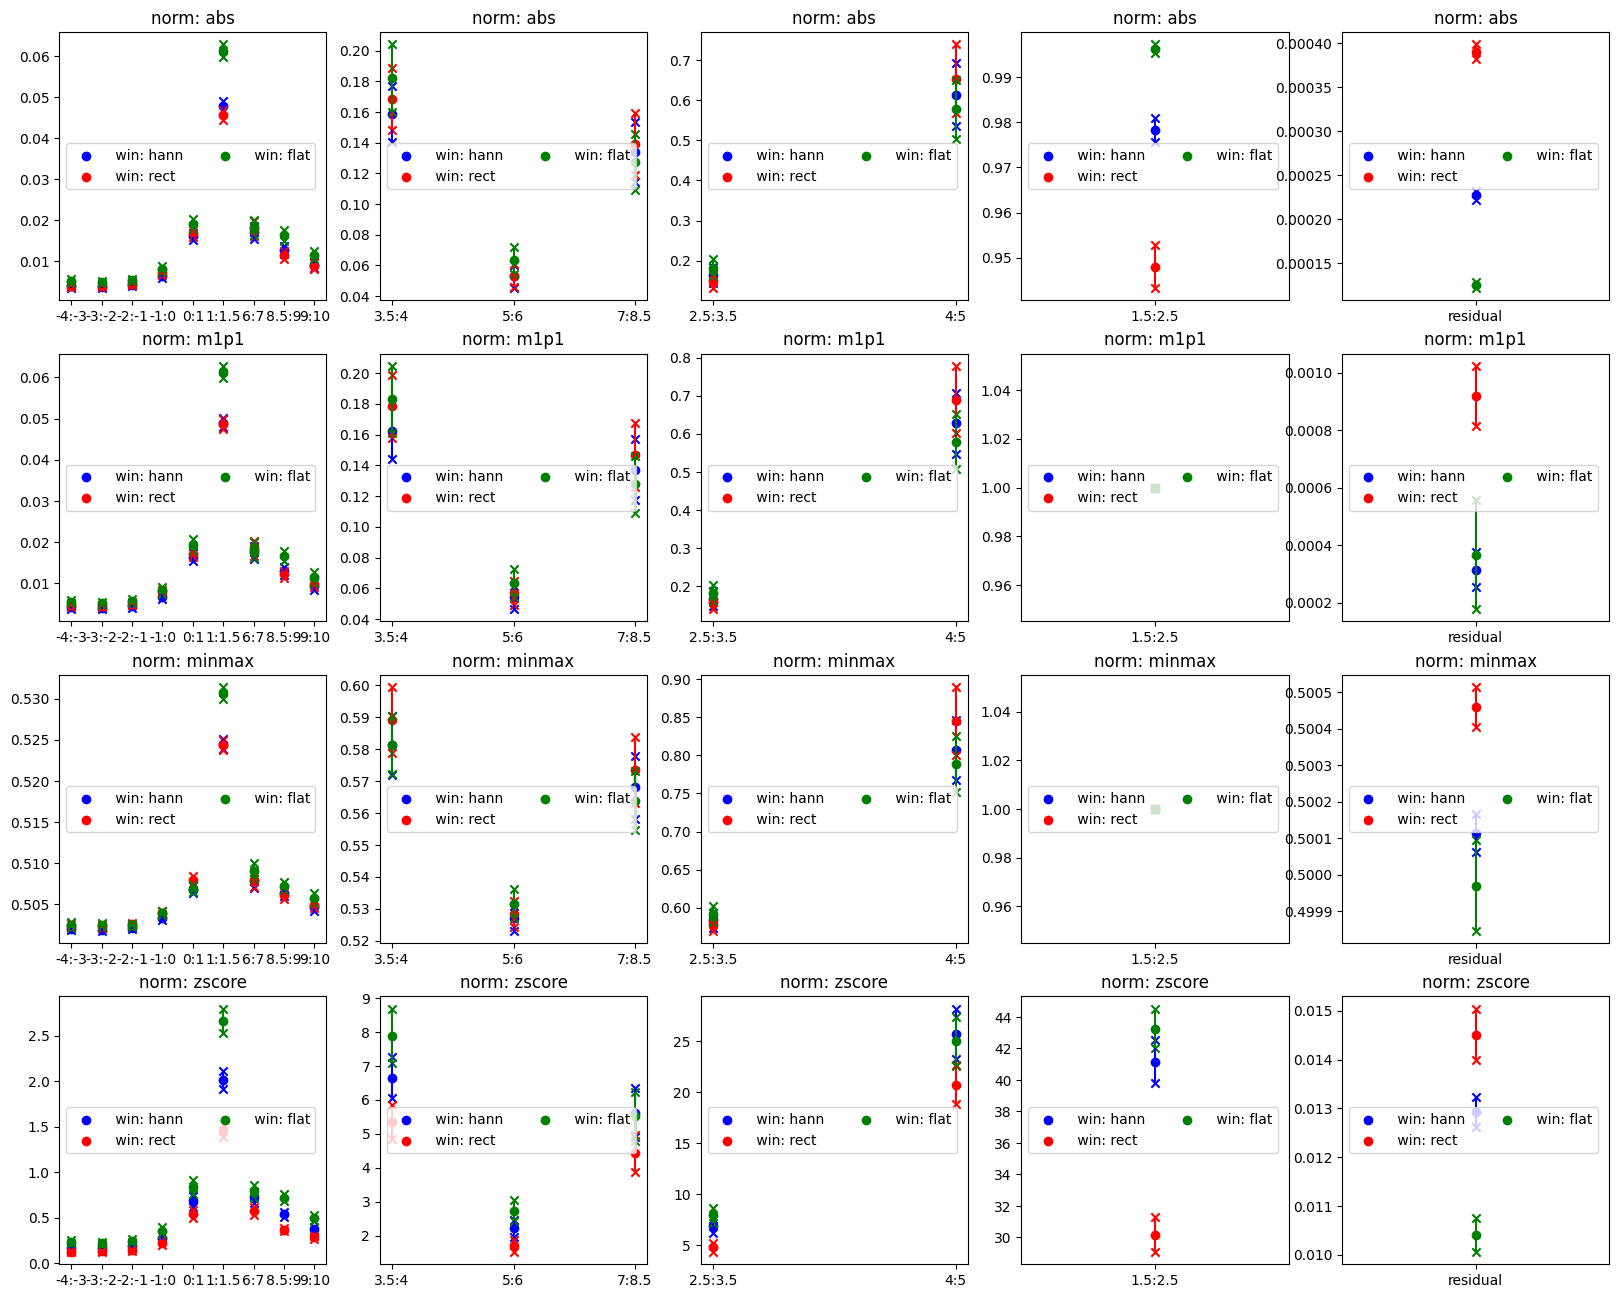

In [25]:
plot_groups = [[0,1,2,3,4,5,11,13,14],[8,10,12],[7,9],[6],[-1]]
colors = ['b','r','g']
fig,ax = plt.subplots(4,5,figsize=(20,16))
for i in range(len(norm_)):
    for j in range(len(window_)):
        aux = np.array(max_sec['norm_'+norm_[i]]['window_'+win_name[j]]['mean'])
        aux_std = np.array(max_sec['norm_'+norm_[i]]['window_'+win_name[j]]['std'])
        for gr_id,group in enumerate(plot_groups):
            for k_id,k in enumerate(group):
                if k_id== 0:
                    ax.flat[5*i+gr_id].scatter(section_list[k],aux[k],label=' win: '+win_name[j],color=colors[j])
                else:
                    ax.flat[5*i+gr_id].scatter(section_list[k],aux[k],color=colors[j])
                ax.flat[5*i+gr_id].scatter(section_list[k],(aux+aux_std)[k],color=colors[j], marker='x')
                ax.flat[5*i+gr_id].scatter(section_list[k],(aux-aux_std)[k],color=colors[j], marker='x')
                ax.flat[5*i+gr_id].vlines(section_list[k],(aux-aux_std)[k],(aux+aux_std)[k],color=colors[j])
    for gr_id,group in enumerate(plot_groups):
        ax.flat[5*i+gr_id].legend(loc='center left',ncols=2)
        ax.flat[5*i+gr_id].set_title('norm: '+norm_[i])

Using these values we can segment the regions of the image:

In [26]:
regions = {'abs':[0.001,0.02,0.08,0.2,0.8],'m1p1':[0.001,0.02,0.08,0.2,0.8],'minmax':[0.0005,0.01,0.04,0.1,0.4],'zscore':[0.015,1,3,10,25]}

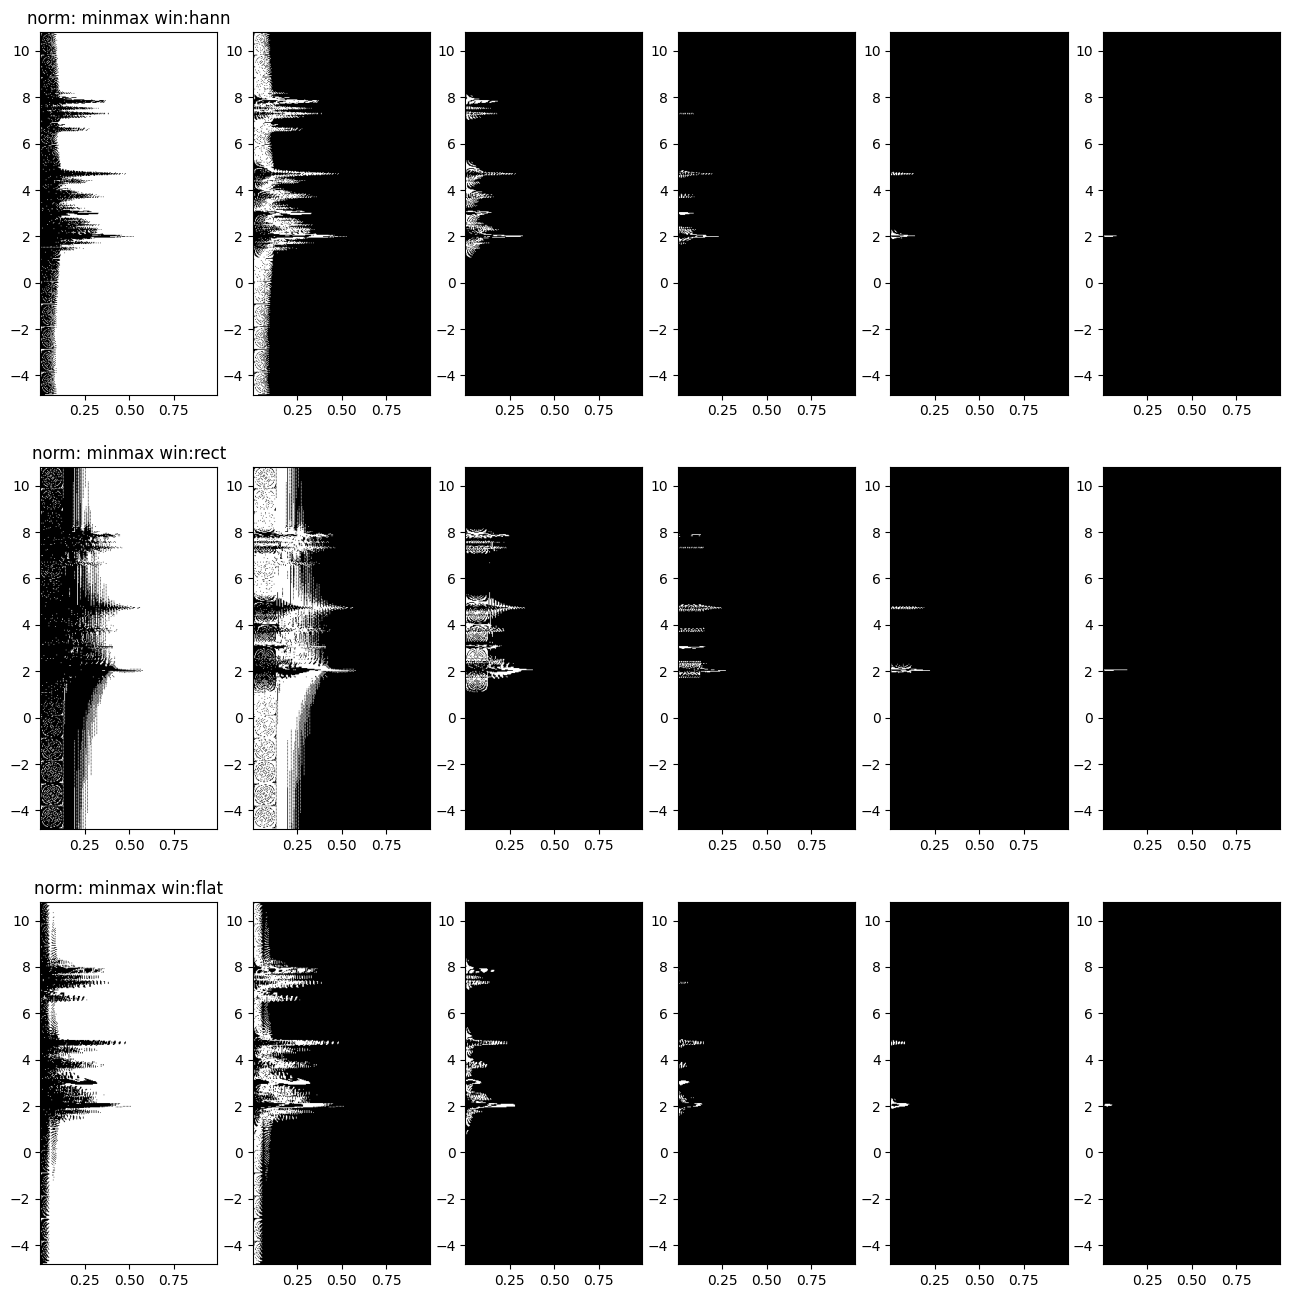

In [27]:
norm_plot = 'minmax'
fig,ax = plt.subplots(3,6,figsize=(16,16))
for j in range(len(window_)):
    if norm_plot == 'minmax':
        aux_bin = np.abs(np.real(spgram_wn['norm_'+norm_plot]['window_'+win_name[j]][0][0,:,:])-0.5)
    else:
        aux_bin = np.abs(np.real(spgram_wn['norm_'+norm_plot]['window_'+win_name[j]][0][0,:,:]))
    seg_res = (aux_bin < regions[norm_plot][0]).astype('int')
    seg_res2 = (aux_bin > regions[norm_plot][0]).astype('int')*(aux_bin < regions[norm_plot][1]).astype('int')
    seg_res3 = (aux_bin > regions[norm_plot][1]).astype('int')*(aux_bin < regions[norm_plot][2]).astype('int')
    seg_res4 = (aux_bin > regions[norm_plot][2]).astype('int')*(aux_bin < regions[norm_plot][3]).astype('int')
    seg_res5 = (aux_bin > regions[norm_plot][3]).astype('int')*(aux_bin < regions[norm_plot][4]).astype('int')
    seg_res6 = (aux_bin > regions[norm_plot][4]).astype('int')
    extent_seq = (spgram_wn['norm_'+norm_plot]['window_'+win_name[j]][-1][0],spgram_wn['norm_'+norm_plot]['window_'+win_name[j]][-1][-1],
                  np.flip(spgram_wn['norm_'+norm_plot]['window_'+win_name[j]][2])[0],np.flip(spgram_wn['norm_'+norm_plot]['window_'+win_name[j]][2])[-1])
    ax.flat[6*j].imshow(seg_res,cmap='gray',origin='lower',aspect='auto',
                    extent = extent_seq)
    ax.flat[6*j+1].imshow(seg_res2,cmap='gray',origin='lower',aspect='auto',
                    extent = extent_seq)
    ax.flat[6*j+2].imshow(seg_res3,cmap='gray',origin='lower',aspect='auto',
                    extent = extent_seq)
    ax.flat[6*j+3].imshow(seg_res4,cmap='gray',origin='lower',aspect='auto',
                    extent = extent_seq)
    ax.flat[6*j+4].imshow(seg_res5,cmap='gray',origin='lower',aspect='auto',
                    extent = extent_seq)
    ax.flat[6*j+5].imshow(seg_res6,cmap='gray',origin='lower',aspect='auto',
                    extent = extent_seq)
    ax.flat[6*j].set_title('norm: '+norm_plot+' win:'+win_name[j])

% of pixels in each segmented region:

In [28]:
qntty_percent_regions = {}
for i in range(len(norm_)):
    if norm_[i] == 'minmax':
        aux = {}
        for j in range(len(window_)):
            aux['window_'+win_name[j]] = [spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0] - 0.5,spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][1],spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][2],spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][3]]
    else:
        aux = spgram_wn['norm_'+norm_[i]]
    hist, bins, bins_centered, qntty_percent_regions['norm_'+norm_[i]] = funcstud.histogram_for_different_spgram_and_qntty_per_histogram_region(spgram_dict=aux,nbins=5000,part='real',regions=regions[norm_[i]],normalized=True)

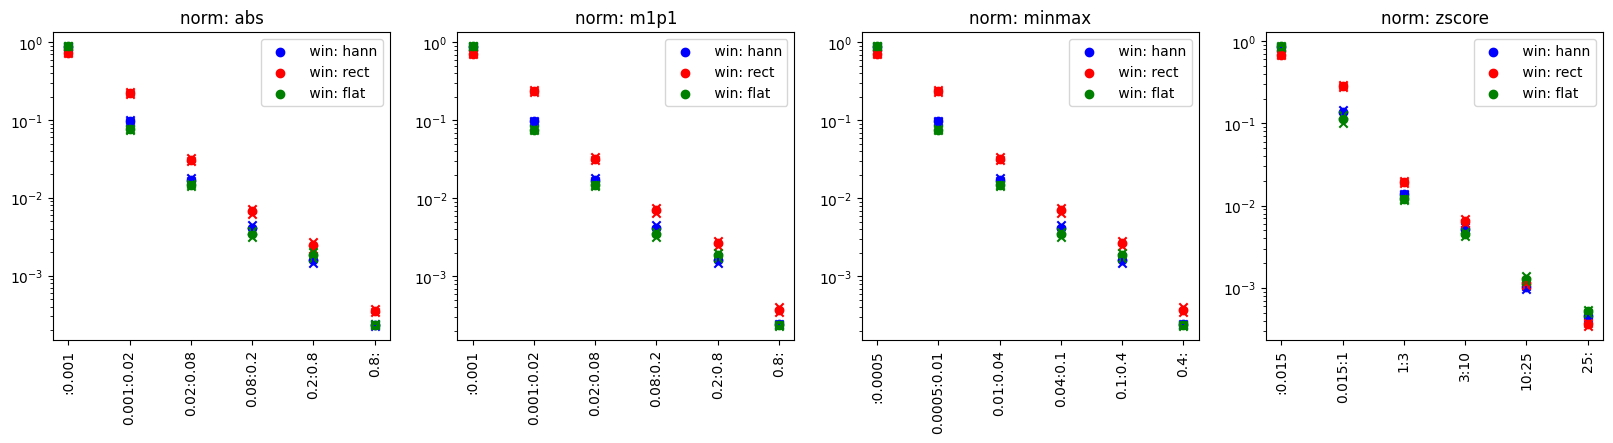

In [29]:
colors = ['b','r','g']
fig,ax = plt.subplots(1,4,figsize=(20,4))
for i in range(len(norm_)):
    reg_list  = list(qntty_percent_regions['norm_'+norm_[i]].keys())
    for reg_id,reg in enumerate(reg_list):
            aux = np.array(qntty_percent_regions['norm_'+norm_[i]][reg]['mean'])
            aux_std = np.array(qntty_percent_regions['norm_'+norm_[i]][reg]['std'])
            for j in range(len(window_)):
                if reg_id == 0:
                    ax.flat[i].scatter(reg,aux[j],label=' win: '+win_name[j],color=colors[j])
                else:
                    ax.flat[i].scatter(reg,aux[j],color=colors[j])
                ax.flat[i].scatter(reg,(aux+aux_std)[j],color=colors[j], marker='x')
                ax.flat[i].scatter(reg,(aux-aux_std)[j],color=colors[j], marker='x')
                ax.flat[i].vlines(reg,(aux-aux_std)[j],(aux+aux_std)[j],color=colors[j])
    ax.flat[i].legend(loc='upper right')
    ax.flat[i].set_title('norm: '+norm_[i])
    ax.flat[i].set_xticks(range(len(reg_list)))
    ax.flat[i].set_xticklabels(reg_list, rotation=90)
    ax.flat[i].set_yscale('log')

Stats of each segmented region x norm/window:

In [30]:
stats_per_region = {}
for i in range(len(norm_)):
    if norm_[i] == 'minmax':
        stats_per_region['norm_'+norm_[i]] = funcstud.stats_per_segmented_regions_for_different_spgrams(regions_threshold=regions[norm_[i]],spgram_dict=spgram_wn['norm_'+norm_[i]], part='real', not_zero_centered=True, center_value=0.5)
    else:
        stats_per_region['norm_'+norm_[i]] = funcstud.stats_per_segmented_regions_for_different_spgrams(regions_threshold=regions[norm_[i]],spgram_dict=spgram_wn['norm_'+norm_[i]], part='real')

In [31]:
stats_global = {}
for i in range(len(norm_)):
    stats_global['norm_'+norm_[i]] = utils.stats_global_for_different_spgrams(spgram_dict=spgram_wn['norm_'+norm_[i]], part='part')

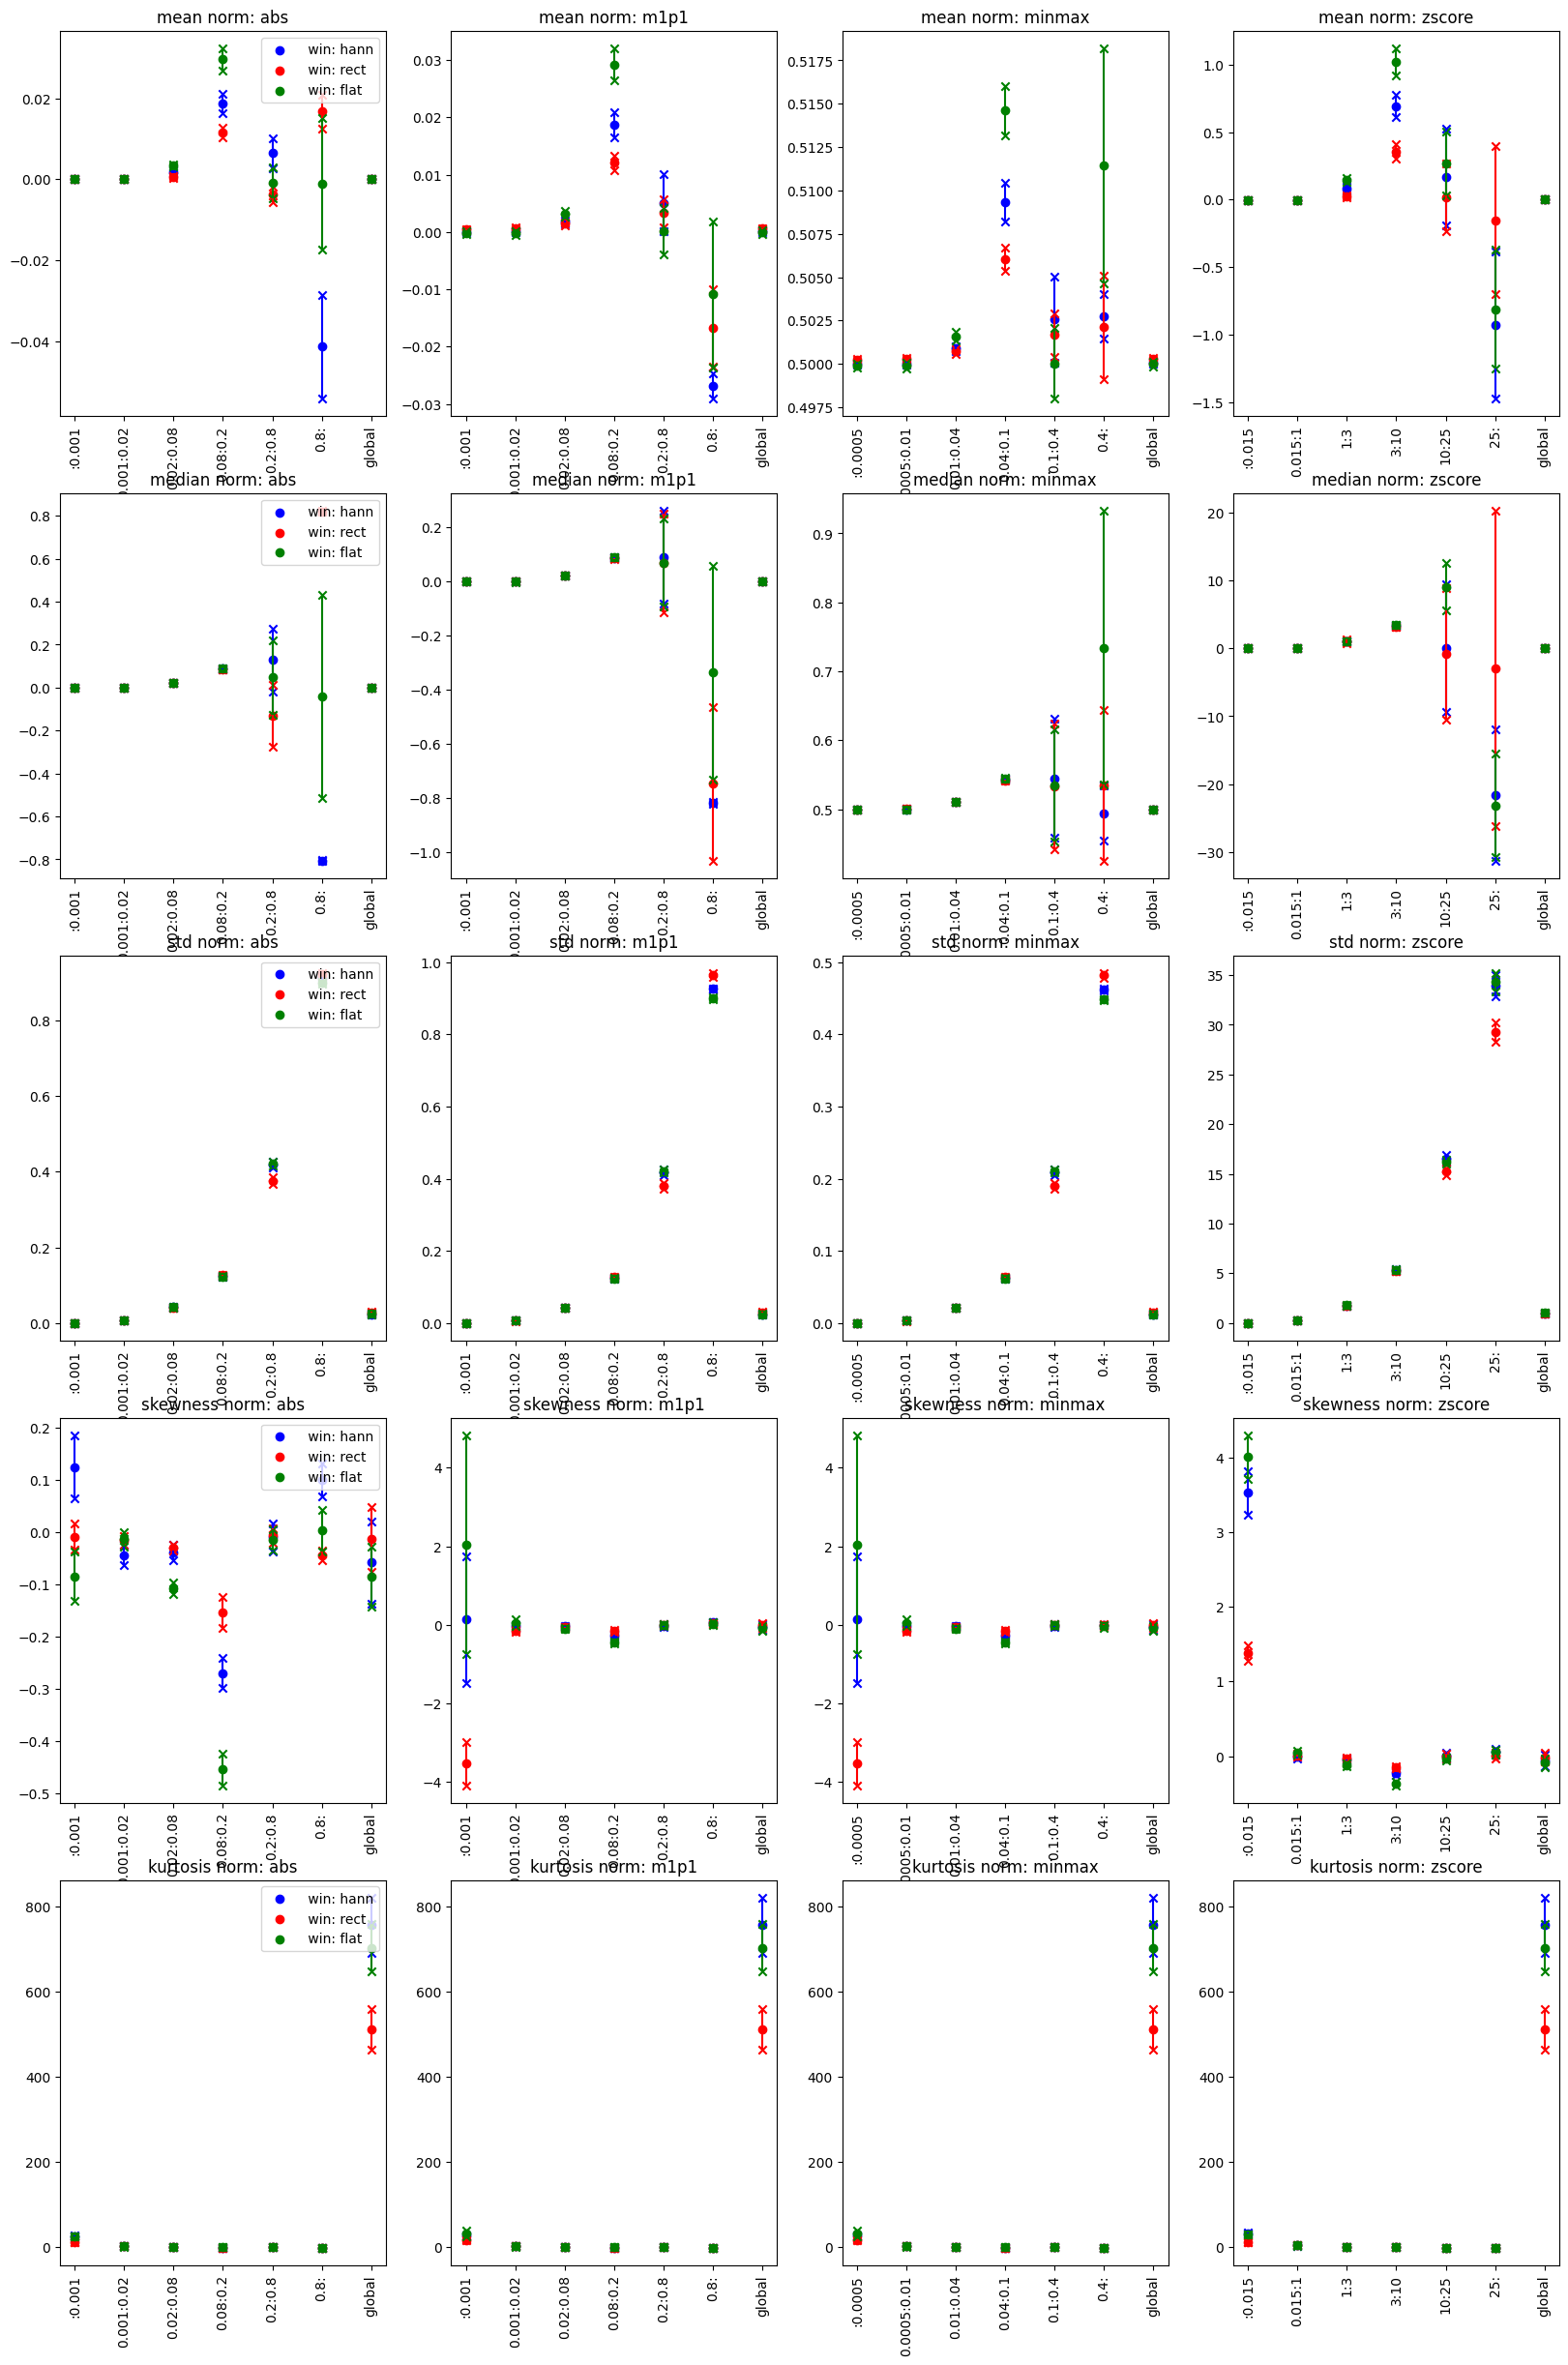

In [32]:
colors = ['b','r','g']
fig,ax = plt.subplots(5,4,figsize=(20,30))
stats_list = list(stats_per_region['norm_'+norm_[0]].keys())
for sta_id,sta in enumerate(stats_list):
    for i in range(len(norm_)):
        reg_list  = list(stats_per_region['norm_'+norm_[i]][sta].keys())
        for reg_id in range(len(reg_list)+1):
            if reg_id != len(reg_list):
                reg = reg_list[reg_id]
                aux = np.array(stats_per_region['norm_'+norm_[i]][sta][reg]['mean'])
                aux_std = np.array(stats_per_region['norm_'+norm_[i]][sta][reg]['std'])
            else:
                reg = 'global'
                aux = np.array(stats_global['norm_'+norm_[i]][sta]['mean'])
                aux_std = np.array(stats_global['norm_'+norm_[i]][sta]['std'])
            for j in range(len(window_)):
                if reg_id == 0:
                    ax.flat[4*sta_id+i].scatter(reg,aux[j],label=' win: '+win_name[j],color=colors[j])
                else:
                    ax.flat[4*sta_id+i].scatter(reg,aux[j],color=colors[j])
                ax.flat[4*sta_id+i].scatter(reg,(aux+aux_std)[j],color=colors[j], marker='x')
                ax.flat[4*sta_id+i].scatter(reg,(aux-aux_std)[j],color=colors[j], marker='x')
                ax.flat[4*sta_id+i].vlines(reg,(aux-aux_std)[j],(aux+aux_std)[j],color=colors[j])
        if i == 0:
            ax.flat[4*sta_id+i].legend(loc='upper right')
        ax.flat[4*sta_id+i].set_title(sta+' norm: '+norm_[i])
        ax.flat[4*sta_id+i].set_xticks(range(len(reg_list)+1))
        ax.flat[4*sta_id+i].set_xticklabels(reg_list+['global'], rotation=90)

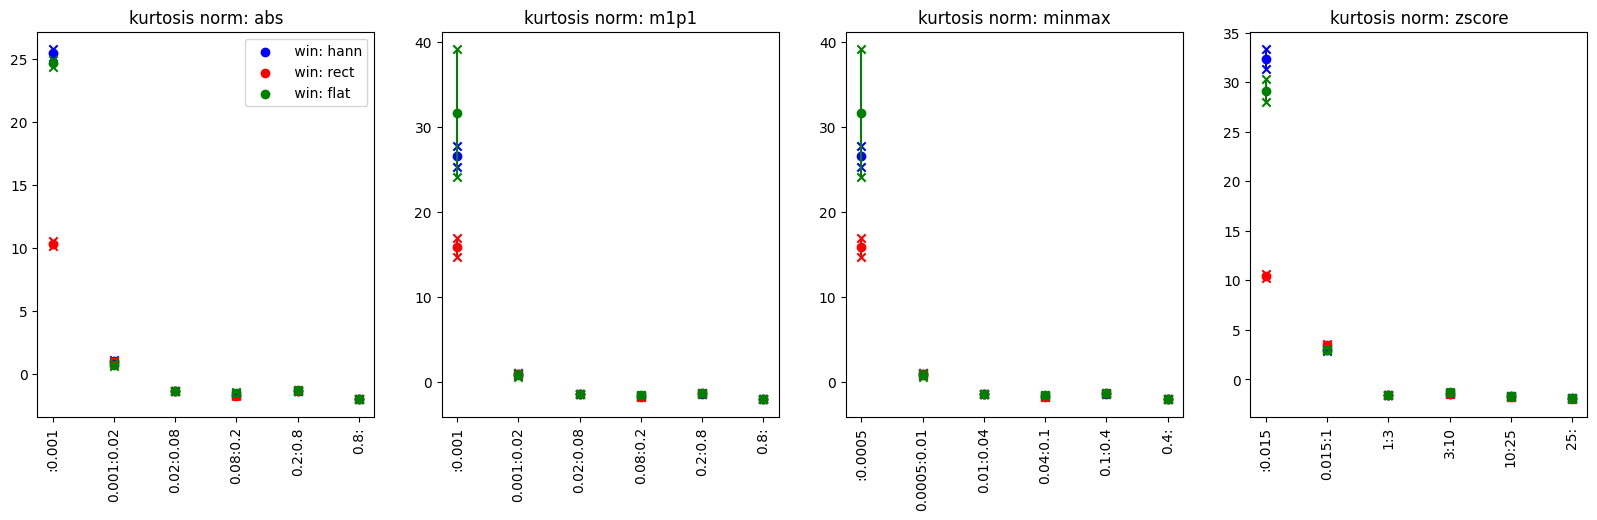

In [33]:
colors = ['b','r','g']
fig,ax = plt.subplots(1,4,figsize=(20,5))
for i in range(len(norm_)):
    reg_list  = list(stats_per_region['norm_'+norm_[i]]['kurtosis'].keys())
    for reg_id in range(len(reg_list)):
        reg = reg_list[reg_id]
        aux = np.array(stats_per_region['norm_'+norm_[i]]['kurtosis'][reg]['mean'])
        aux_std = np.array(stats_per_region['norm_'+norm_[i]]['kurtosis'][reg]['std'])
        for j in range(len(window_)):
            if reg_id == 0:
                ax.flat[i].scatter(reg,aux[j],label=' win: '+win_name[j],color=colors[j])
            else:
                ax.flat[i].scatter(reg,aux[j],color=colors[j])
            ax.flat[i].scatter(reg,(aux+aux_std)[j],color=colors[j], marker='x')
            ax.flat[i].scatter(reg,(aux-aux_std)[j],color=colors[j], marker='x')
            ax.flat[i].vlines(reg,(aux-aux_std)[j],(aux+aux_std)[j],color=colors[j])
        if i == 0:
            ax.flat[i].legend(loc='upper right')
        ax.flat[i].set_title('kurtosis'+' norm: '+norm_[i])
        ax.flat[i].set_xticks(range(len(reg_list)))
        ax.flat[i].set_xticklabels(reg_list, rotation=90)
        #ax.flat[5*sta_id+i].set_yscale('log')

In [34]:
stat_check = 'kurtosis'
print(stats_per_region['norm_'+norm_[0]][stat_check][':0.001']['mean'],np.argmin(np.array(stats_per_region['norm_'+norm_[0]][stat_check][':0.001']['mean'])),np.argmax(np.array(stats_per_region['norm_'+norm_[0]][stat_check][':0.001']['mean'])))
print(stats_per_region['norm_'+norm_[1]][stat_check][':0.001']['mean'],np.argmin(np.array(stats_per_region['norm_'+norm_[1]][stat_check][':0.001']['mean'])),np.argmax(np.array(stats_per_region['norm_'+norm_[1]][stat_check][':0.001']['mean'])))
print(stats_per_region['norm_'+norm_[2]][stat_check][':0.0005']['mean'],np.argmin(np.array(stats_per_region['norm_'+norm_[2]][stat_check][':0.0005']['mean'])),np.argmax(np.array(stats_per_region['norm_'+norm_[2]][stat_check][':0.0005']['mean'])))
print(stats_per_region['norm_'+norm_[3]][stat_check][':0.015']['mean'],np.argmin(np.array(stats_per_region['norm_'+norm_[3]][stat_check][':0.015']['mean'])),np.argmax(np.array(stats_per_region['norm_'+norm_[3]][stat_check][':0.015']['mean'])))

[25.42342606971276, 10.34125790486095, 24.643126061338243] 1 0
[26.5921893052589, 15.864591126354101, 31.622486360911125] 1 2
[26.592189305257957, 15.864591126353858, 31.62248636090903] 1 2
[32.30119516677411, 10.482417468134862, 29.144735261425332] 1 0


(0.0, 500.0)

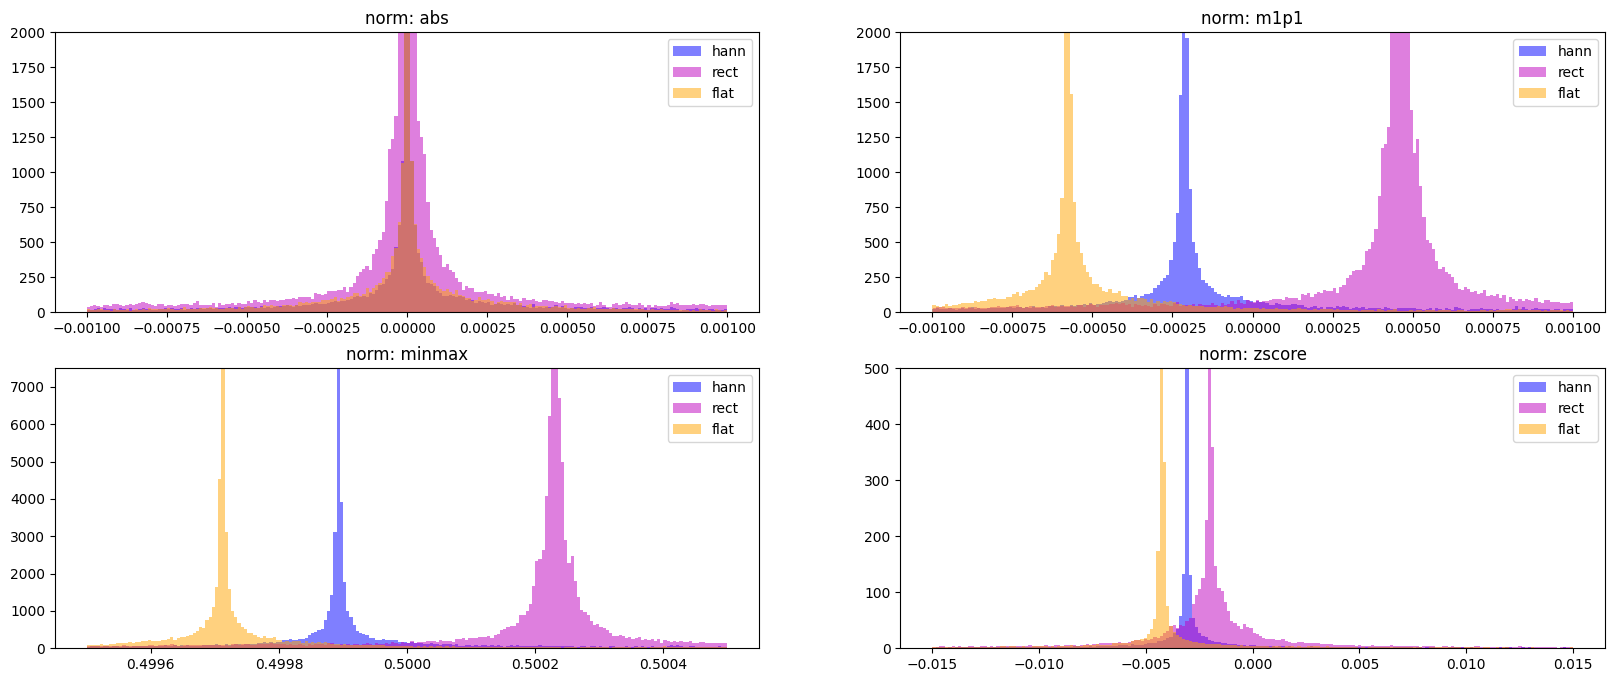

In [35]:
jfig,ax = plt.subplots(2,2,figsize=(20,8))
colors=['b','m','orange']
for i in range(len(norm_)):
    for j in range(len(window_)):
        if i == 2:
            seg_ = np.abs(np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0][0,:,:])-0.5) < regions[norm_[i]][0]
        else:
            seg_ = np.abs(np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0][0,:,:])) < regions[norm_[i]][0]
        aux = np.real(seg_*spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0][0,:,:]).ravel()
        aux = aux[aux != 0]
        im=ax.flat[i].hist(aux,200,density = True,alpha=0.5,color=colors[j],label=win_name[j])
    ax.flat[i].legend(loc='upper right')
    ax.flat[i].set_title('norm: '+norm_[i])
ax.flat[0].set_ylim(0,2000)
ax.flat[1].set_ylim(0,2000)
ax.flat[2].set_ylim(0,7500)
ax.flat[3].set_ylim(0,500)

In [36]:
stat_check = 'skewness'
by_region = True
if by_region == True:
    for k in range(1,len(regions[norm_[i]])+1):
        print('region',k)
        for i in range(len(norm_)):
            if k < len(regions[norm_[i]]):
                print(stats_per_region['norm_'+norm_[i]][stat_check][str(regions[norm_[i]][k-1])+':'+str(regions[norm_[i]][k])]['mean'],np.argmin(np.array(stats_per_region['norm_'+norm_[i]][stat_check][str(regions[norm_[i]][k-1])+':'+str(regions[norm_[i]][k])]['mean'])),np.argmax(np.array(stats_per_region['norm_'+norm_[i]][stat_check][str(regions[norm_[i]][k-1])+':'+str(regions[norm_[i]][k])]['mean'])))
            else:
                print(stats_per_region['norm_'+norm_[i]][stat_check][str(regions[norm_[i]][k-1])+':']['mean'],np.argmin(np.array(stats_per_region['norm_'+norm_[i]][stat_check][str(regions[norm_[i]][k-1])+':']['mean'])),np.argmax(np.array(stats_per_region['norm_'+norm_[i]][stat_check][str(regions[norm_[i]][k-1])+':']['mean'])))
else:
    for i in range(len(norm_)):
        print(norm_[i])
        for k in range(1,len(regions[norm_[i]])+1):
            if k < len(regions[norm_[i]]):
                print(stats_per_region['norm_'+norm_[i]][stat_check][str(regions[norm_[i]][k-1])+':'+str(regions[norm_[i]][k])]['mean'],np.argmin(np.array(stats_per_region['norm_'+norm_[i]][stat_check][str(regions[norm_[i]][k-1])+':'+str(regions[norm_[i]][k])]['mean'])),np.argmax(np.array(stats_per_region['norm_'+norm_[i]][stat_check][str(regions[norm_[i]][k-1])+':'+str(regions[norm_[i]][k])]['mean'])))
            else:
                print(stats_per_region['norm_'+norm_[i]][stat_check][str(regions[norm_[i]][k-1])+':']['mean'],np.argmin(np.array(stats_per_region['norm_'+norm_[i]][stat_check][str(regions[norm_[i]][k-1])+':']['mean'])),np.argmax(np.array(stats_per_region['norm_'+norm_[i]][stat_check][str(regions[norm_[i]][k-1])+':']['mean'])))

region 1
[-0.043559430480225245, -0.015575763952790991, -0.013167301786310443] 0 2
[-0.04149067167363722, -0.15564471300669347, 0.0488233424930171] 1 2
[-0.04149067167363633, -0.15564471300668814, 0.04882334249301641] 1 2
[-0.011342077588585651, 0.007592577706383433, 0.043873004053641834] 0 2
region 2
[-0.038623472348562136, -0.02979773748424868, -0.1067320165054894] 2 1
[-0.03545034320368701, -0.06501387535861976, -0.09374416201977664] 2 0
[-0.03545034320368534, -0.06501387535861994, -0.09374416201977612] 2 0
[-0.0494953555487045, -0.033948479809680736, -0.11924138904887645] 2 1
region 3
[-0.27016008806545383, -0.1540438452603674, -0.45430806001672325] 2 1
[-0.26691358500527007, -0.14959184531493644, -0.44688655071093664] 2 1
[-0.2669135850052707, -0.14959184531493644, -0.4468865507109366] 2 1
[-0.23260342261651573, -0.14730776161368983, -0.36770839144533907] 2 1
region 4
[-0.009874157309444074, -0.0060783727116454885, -0.014466511382456226] 2 1
[-0.017822813207759226, 0.0025458613560

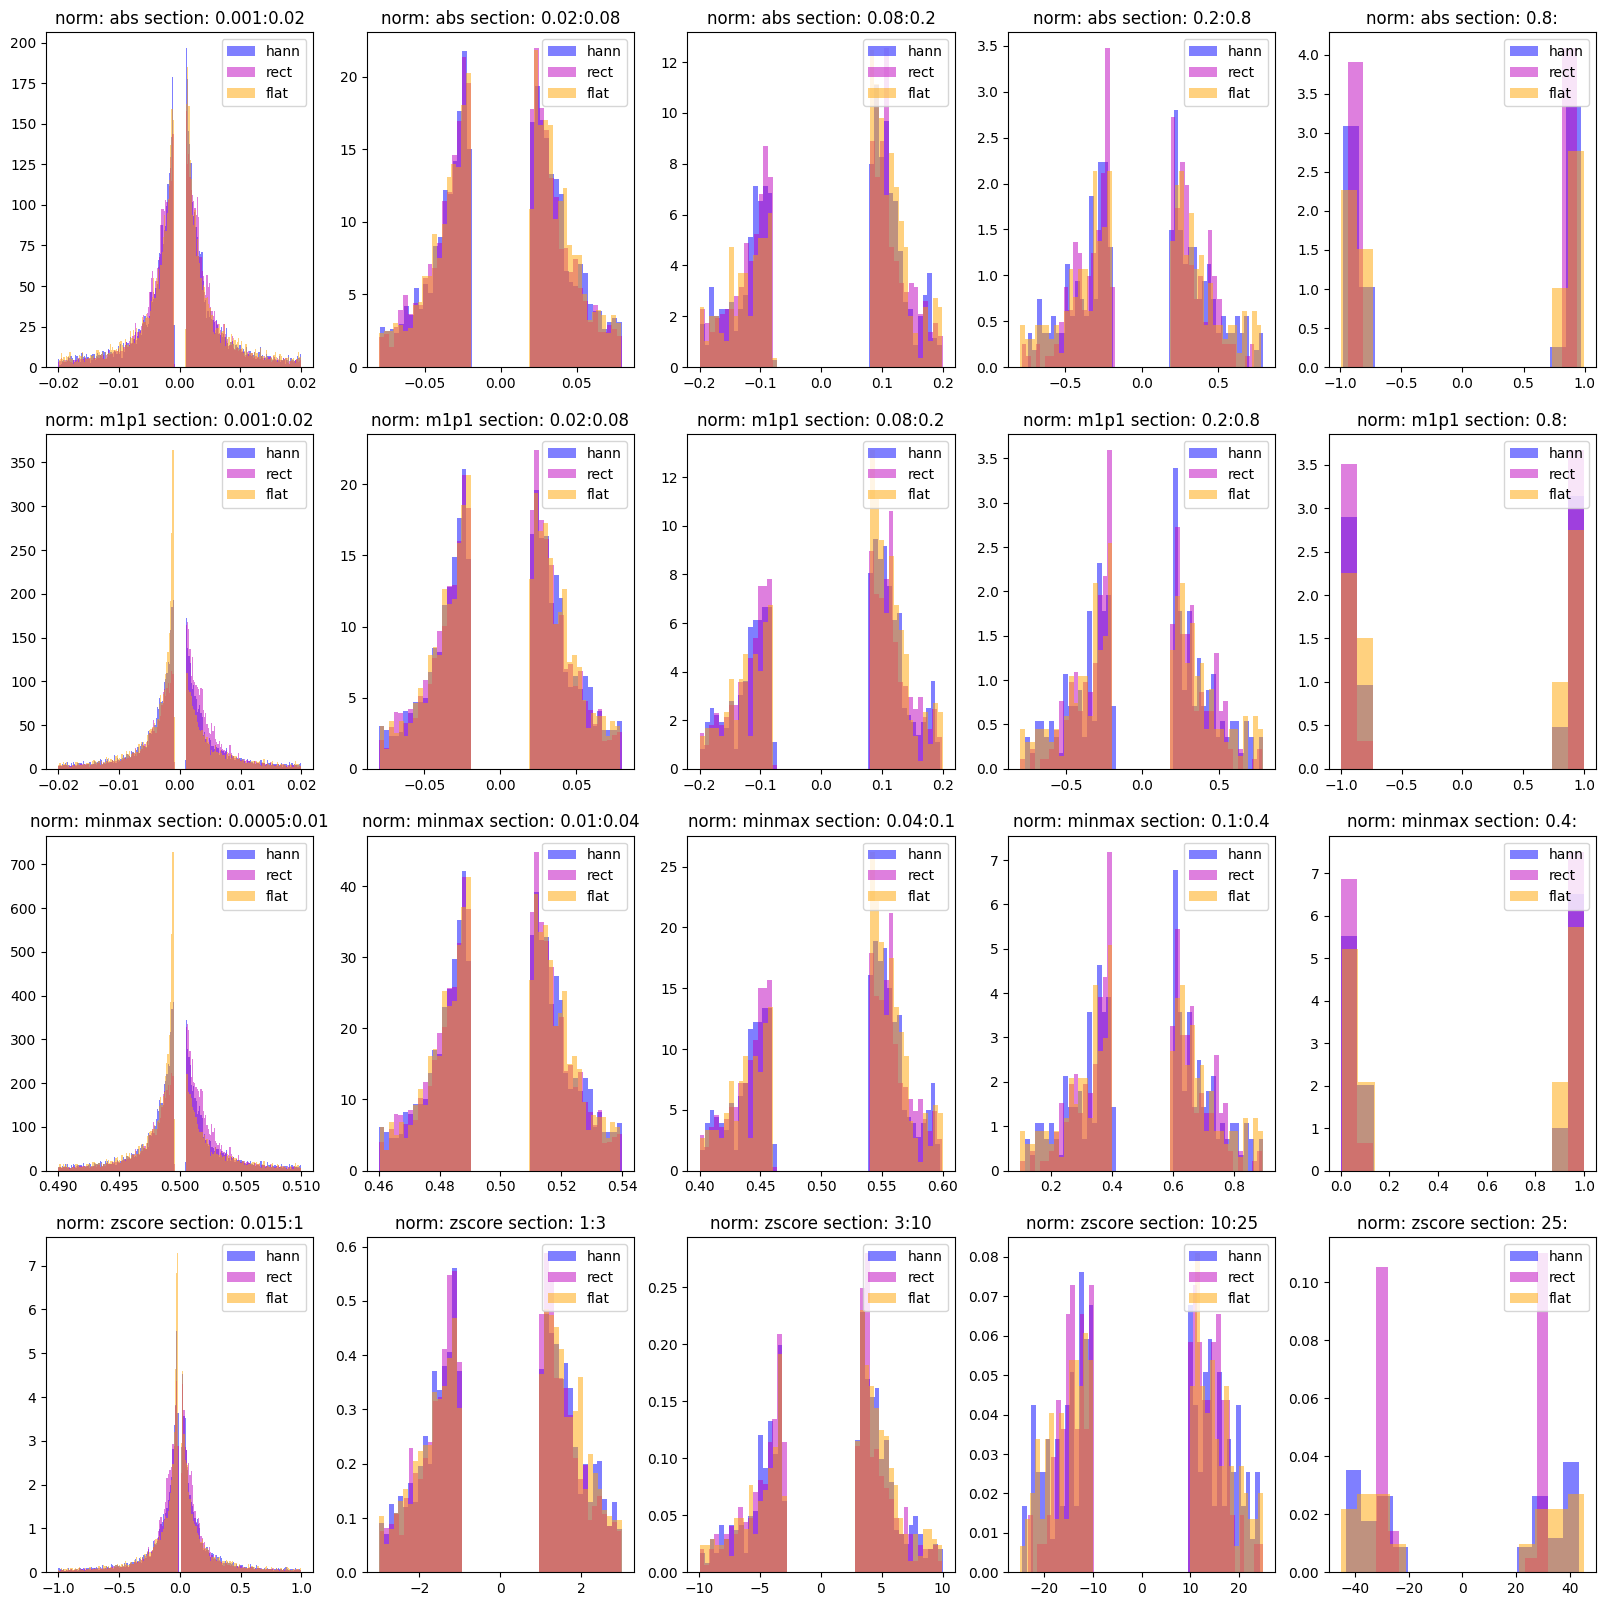

In [37]:
jfig,ax = plt.subplots(4,5,figsize=(20,20))
colors=['b','m','orange']
plot_bins = [200,50,50,50,15]
for i in range(len(norm_)):
    for k in range(1,len(regions[norm_[i]])+1):
        for j in range(len(window_)):
            if i == 2:
                if k < len(regions[norm_[i]]):
                    seg_ = (np.abs(np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0][0,:,:])-0.5) > regions[norm_[i]][k-1])*(np.abs(np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0][0,:,:])-0.5) < regions[norm_[i]][k])
                else:
                    seg_ = np.abs(np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0][0,:,:])-0.5) > regions[norm_[i]][k-1]
            else:
                if k < len(regions[norm_[i]]):
                    seg_ = (np.abs(np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0][0,:,:])) > regions[norm_[i]][k-1])*(np.abs(np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0][0,:,:])) < regions[norm_[i]][k])
                else:
                    seg_ = np.abs(np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0][0,:,:])) > regions[norm_[i]][k-1]
            aux = np.real(seg_*spgram_wn['norm_'+norm_[i]]['window_'+win_name[j]][0][0,:,:]).ravel()
            aux = aux[aux != 0]
            im=ax.flat[5*i+(k-1)].hist(aux,plot_bins[k-1],density = True,alpha=0.5,color=colors[j],label=win_name[j])
        ax.flat[5*i+(k-1)].legend(loc='upper right')
        if k < len(regions[norm_[i]]):
            ax.flat[5*i+(k-1)].set_title('norm: '+norm_[i]+' section: '+str(regions[norm_[i]][k-1])+':'+str(regions[norm_[i]][k]))
        else:
            ax.flat[5*i+(k-1)].set_title('norm: '+norm_[i]+' section: '+str(regions[norm_[i]][k-1])+':')

In [38]:
stat_check = 'kurtosis'
print(stats_global['norm_'+norm_[0]][stat_check]['mean'],np.argmin(np.array(stats_global['norm_'+norm_[0]][stat_check]['mean'])),np.argmax(np.array(stats_global['norm_'+norm_[0]][stat_check]['mean'])))
print(stats_global['norm_'+norm_[1]][stat_check]['mean'],np.argmin(np.array(stats_global['norm_'+norm_[1]][stat_check]['mean'])),np.argmax(np.array(stats_global['norm_'+norm_[1]][stat_check]['mean'])))
print(stats_global['norm_'+norm_[2]][stat_check]['mean'],np.argmin(np.array(stats_global['norm_'+norm_[2]][stat_check]['mean'])),np.argmax(np.array(stats_global['norm_'+norm_[2]][stat_check]['mean'])))
print(stats_global['norm_'+norm_[3]][stat_check]['mean'],np.argmin(np.array(stats_global['norm_'+norm_[3]][stat_check]['mean'])),np.argmax(np.array(stats_global['norm_'+norm_[3]][stat_check]['mean'])))

[756.8988311326237, 511.9072049380626, 704.0822336368562] 1 0
[756.8988311326237, 511.9072049380626, 704.0822336368562] 1 0
[756.8988311326239, 511.9072049380626, 704.0822336368562] 1 0
[756.8988311326236, 511.9072049380626, 704.0822336368564] 1 0


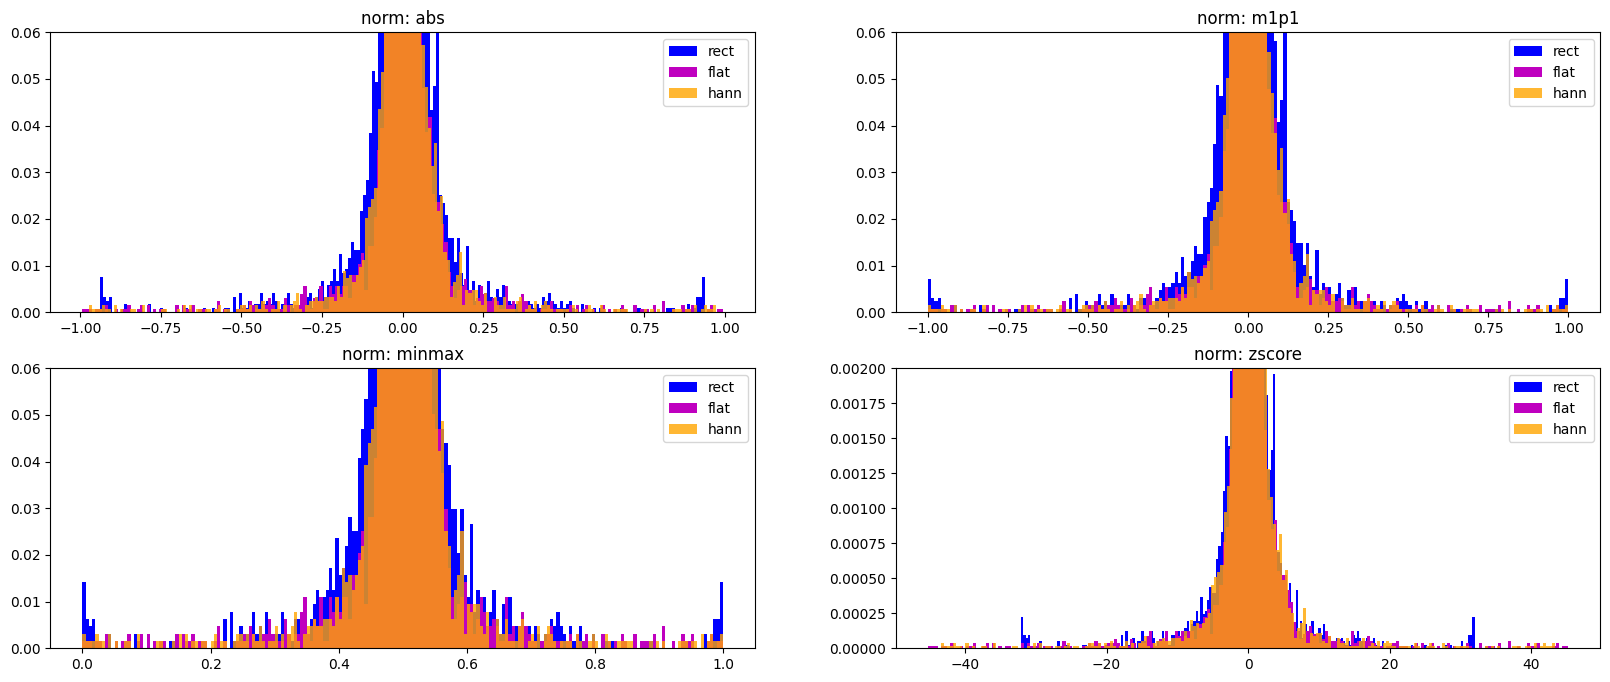

In [39]:
fig,ax = plt.subplots(2,2,figsize=(20,8))
for i in range(len(norm_)):
    im=ax.flat[i].hist(np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[1]][0][0,:,:].flatten()),200,density = True,color='b',label=win_name[1])
    im=ax.flat[i].hist(np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[2]][0][0,:,:].flatten()),200,density = True,color='m',label=win_name[2])
    im=ax.flat[i].hist(np.real(spgram_wn['norm_'+norm_[i]]['window_'+win_name[0]][0][0,:,:].flatten()),200,alpha=0.8,density = True,color='orange',label=win_name[0])
    ax.flat[i].legend(loc='upper right')
    ax.flat[i].set_title('norm: '+norm_[i])
    if i != 3:
        ax.flat[i].set_ylim(0,0.06)
    else:
        ax.flat[i].set_ylim(0,0.002)

In [40]:
if test_not_save == False:
    zcr_list = {}
    zcr_list['NAA'] = [{},{},{},{}]
    zcr_list['GABA'] = [{},{},{},{}]
    zcr_list['Glx'] = [{},{},{},{}]
    for ele in ['NAA','GABA','Glx']:
        for i in range(len(norm_)):
            zcr_list[ele][i]['mean'] = list(zcr_[ele][i]['mean'])
            zcr_list[ele][i]['std'] = list(zcr_[ele][i]['std'])
    with open("quantitative_metrics_no_noise_norm_window_variation_hop_8_mfft_512_CORRECTED.txt", "w") as f:
        f.write("fwhm_wn=")
        f.write(json.dumps(fwhm_wn))
        f.write('\n')
        f.write("fwhm_wn_real=")
        f.write(json.dumps(fwhm_wn_real))
        f.write('\n')
        f.write("sum_segment=")
        f.write(json.dumps(sum_segment))
        f.write('\n')
        f.write("zcr_=")
        f.write(json.dumps(zcr_list))
        f.write('\n')
        f.write("max_sec=")
        f.write(json.dumps(max_sec))
        f.write('\n')
        f.write("qntty_percent_regions=")
        f.write(json.dumps(qntty_percent_regions))
        f.write('\n')
        f.write("stats_per_region=")
        f.write(json.dumps(stats_per_region))
        f.write('\n')
        f.write("stats_global=")
        f.write(json.dumps(stats_global))